# Kalman Filters

# High Level Concepts

Fundamentally, the Kalman Filter is an algorithm that solves the _filtering problem_. The filtering problem involves finding the best estimate $\hat{x}(t)$ of some true process $\vec{x}(t)$ given noisy measurements $\vec{z}(t)$. There are 2 sources of stochastic noise: process noise (noise within $\vec{x}(t)$ itself) and measurement noise. 

To simplify the discussion, we will makes some assumptions: 
- Both forms of noise are gaussian and time-invariant. Both are white noise: the process noise covariance matrix $Q$ and measurement noise covariance matrix $R$ are diagonal matrices.
- The process is linear

Under such assumptions we can represent our process and measurements as follows:

$
\vec{x}(k) = F \vec{x}(k-1) + \vec{\eta}(k)
\\
\vec{z}(k) = H \vec{x}(k) + \vec{\xi}(k)
$

Where $\vec{\eta}(k) \sim \mathcal{N}(0, Q)$ and $\vec{\xi}(k) \sim \mathcal{N}(0, R)$ 

{cite}`young2011recursive` (4.44).

The Kalman Filter algorithm can be summarized as follows. At the $k$-th iteration: 

1. Prediction Step
    - Make a prediction $\hat{x}(k | k-1)$ of the value of state $\vec{x}(k)$ based on the process model and previous state estimate $\vec{x}(k-1)$
    - Update covariance $P$, which quantifies the uncertainty of our estimate, based on the previous value of $P$ and the process noise covariance $Q$.
2. Update Step: Incorporating the measurement $\vec{z}(k)$
    - Update the prediction $\hat{x}(k | k-1)$ with the information $\vec{z}(k)$. The estimate $\hat{x}(k)$ will fall along the residual between the prediction and measurement. The uncertainties of the measurement and prediction are used to calculate the Kalman Gain, which scales how far long that residual vector the estimate $\hat{x}(k)$ will fall. For example, if the measurement's uncertainty (quantified by $R$) is much less than the prediction's uncertainty (quantified by $P$), $\hat{x}(k)$ will fall much closer to $\vec{z}(k)$.

The exact formulas for the algorithm outlined above can be found in {cite}`young2011recursive` Chapter 4.4.

## The Bayesian Intuition underlying the Kalman Filter

In his excellent exploration of the Kalman Filter {cite}`labbe`, Roger Labbe illustrates the bayesian intuition underlying the kalman filter algorithm.

__TODO__ explaining the Bayesian connection is a nice to have, save it for after the core presentation of your implementations is done.

# Implementing the 1D Kalman Filter

Here we implement the 1D Kalman filter and apply it to a simple problem involving global temperature data.

## Implementation

As in {cite}`young2011recursive` (Chapter 4.4, moving body example) we implement the linear Kalman filter to estimate a single state variable over time.

__TODO__ Reference 1D kalman filter implementation code

As Young points out, there is a relationship between the filtering problem and regression. We can transform a regression problem into the filtering problem, then apply Kalman Filter.

## Demonstration on temperature data

To demonstrate this, take the following dataset from NASA {cite}`nasa_temp`, which depicts the annual global average temperature as compared to a baseline temperature (the average temperature over the period of 1951 to 1980):

```{glue:figure} global_temp_data
:figwidth: 400px
:name: "global-temp-fig"
```

There is clearly an upward trend, but the data is noisy - from one year to the next the annual temperature average may go up or down. Furthermore, the upward trend appears nonlinear. How can we determine the trend from the noise?

We may transform this into filtering problem in a few ways:

1. Imagine the temperature is a noisy process and we have perfect measurements.
2. Imagine the temperature is fully deterministic process and we have noisy measurements.
3. Imagine the both the temperature process and our measurements have noise.

Then our kalman filter estimate will be a regression of this temperature data.

__TODO__ Which of the above approaches do I demonstrate.

__TODO__ Insert figure of the global temperature anomalies

__TODO__ Discuss how a linear filter can be applied to this nonlinear problem.

### A linear kalman filter applied to non-linear data

Why was our linear-process-model Kalman Filter able to produce a non-linear regression? Even though we defined a constant "zero-velocity" process for our temperature, since we conceptualize the process as stochastic with some non-zero variance, the measurements can pull the trend upwards.

__TODO__ Show how tuning the Q and R values can make the filter less able to respond to the measurements.

# CODE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from collections import namedtuple
from importlib import reload
from scipy.stats import chi2
from myst_nb import glue
import utils
reload(utils)

rng = np.random.default_rng(seed=1) # TODO I don't think this is the correct way to seed

from IPython.core.debugger import set_trace

# Global Temp Anomaly Data

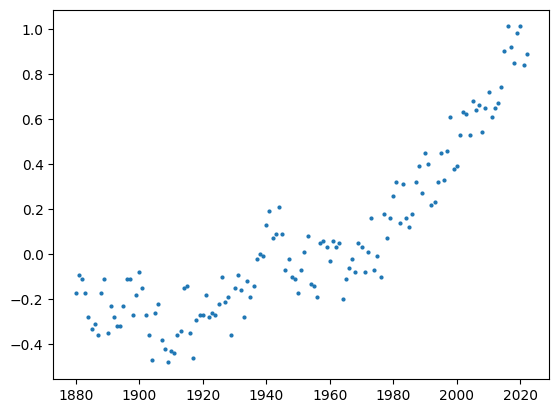

In [2]:
df = pd.read_csv('temp_anomalies.csv')
fig, ax = plt.subplots()
plt.plot(df.year, df.no_smoothing, marker='o', linestyle='none', markersize=2)
#plt.show()
glue("global_temp_data", fig, display=False)

In [3]:
# Named tuples to represent gaussian distributions
Gauss = namedtuple('Gauss', 'mean var')

# Bayesian Style Implementation

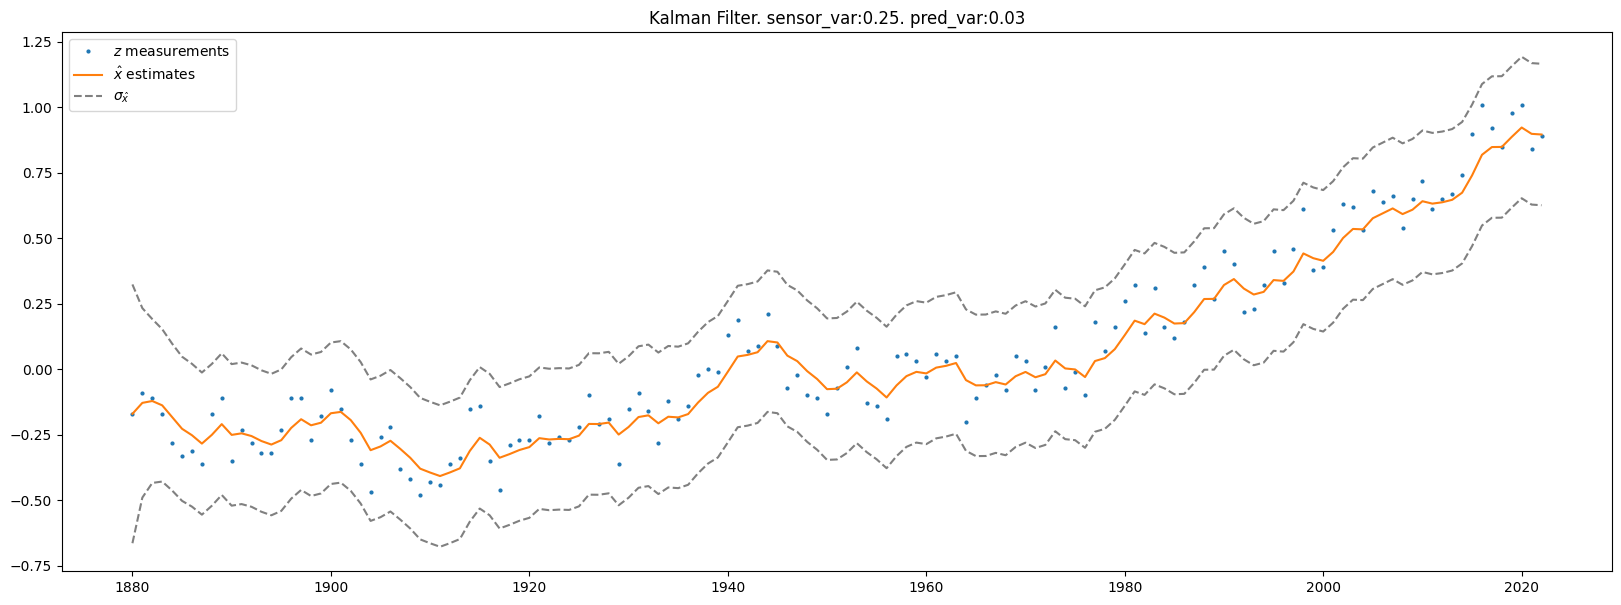

Estimate variance


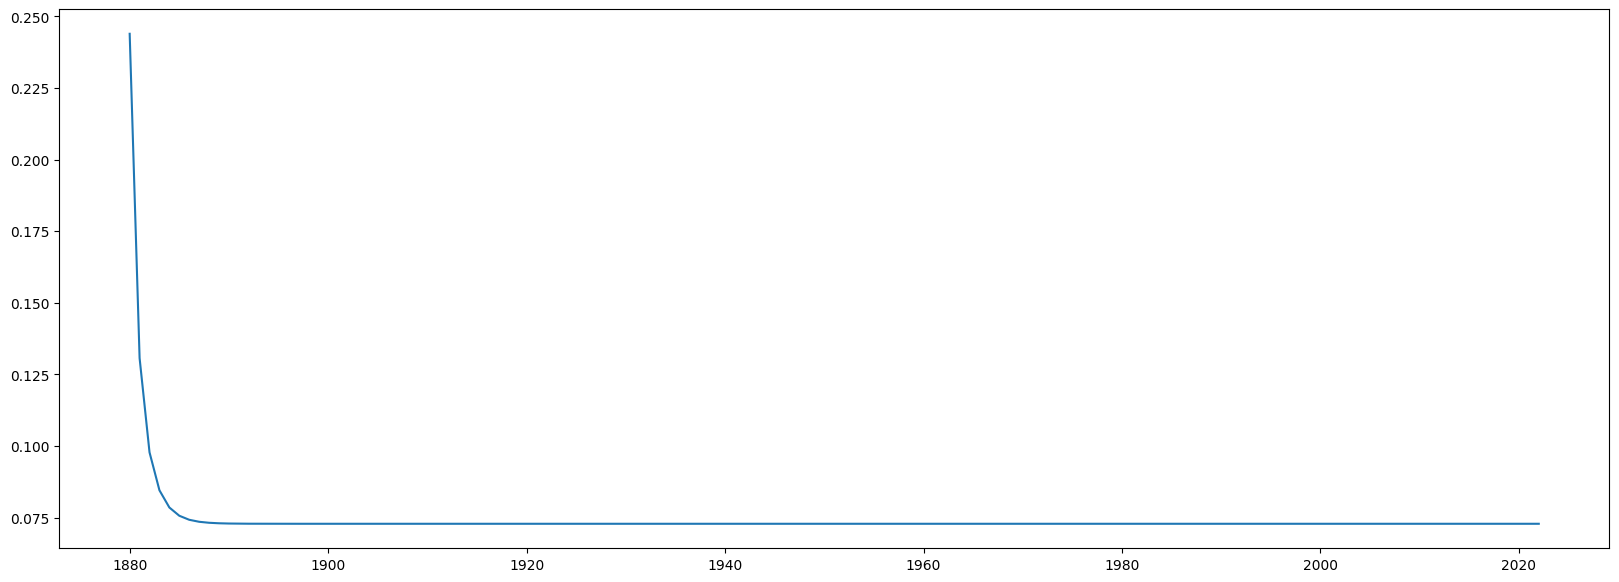

In [4]:
pred_var = 0.03
sensor_var = 0.25

# Measurements
zs = df.no_smoothing

# Initialize system and filter state
# Prior
x_hat = Gauss(zs[0], 10) # Initialize estimate to first measurement value

x_hats = np.full(len(zs), np.nan)
x_hat_vars = np.full(len(zs), np.nan)

for i in range(len(zs)):
    z = zs[i]
    
    # Prediction step - via process model
    dx = Gauss(0, pred_var)
    prior = Gauss(x_hat.mean + dx.mean, x_hat.var + dx.var)
    
    # Update (correct the prediction - from prior to posterior)
    l = Gauss(z, sensor_var) # Likelihood of measurement
    post_mean = (prior.var * l.mean + l.var * prior.mean)/(prior.var + l.var)
    post_var = (prior.var * l.var) / (prior.var + l.var)
    x_hat = Gauss(post_mean, post_var)
    x_hats[i] = x_hat.mean
    x_hat_vars[i] = x_hat.var
    
    # Posterior becomes next iterations prior
    prior = x_hat
    
plt.rcParams["figure.figsize"] = (20,7)
plt.plot(df.year, df.no_smoothing, marker='o', linestyle='none', markersize=2, label=r'$z$ measurements')
plt.plot(df.year, x_hats, label=r'$\hat{x}$ estimates')
plt.plot(df.year, x_hats + np.sqrt(x_hat_vars), linestyle='dashed', color='gray', label='$\sigma_{\hat{x}}$')
plt.plot(df.year, x_hats - np.sqrt(x_hat_vars), linestyle='dashed', color='gray')
plt.title(f'Kalman Filter. sensor_var:{sensor_var}. pred_var:{pred_var}')
plt.legend()
plt.show()

print('Estimate variance')
plt.plot(df.year, x_hat_vars)
plt.show()

# Rewriting in Standard notation

Reimplementing the above using the standard notation:

- $P$: Prior (prediction) variance
- $R$: Measurement noise variance
- $Q$: Process noise variance

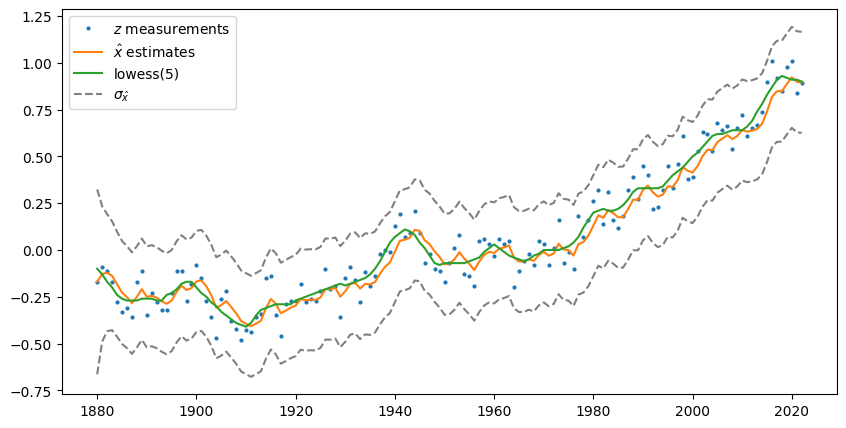

In [5]:
# TODO Docs
def kalman_1d(zs, R, Q, P_0, x_0):
    # Initialize system and filter state
    xs = np.full(len(zs), np.nan)
    Ps = np.full(len(zs), np.nan)
    
    # Prior
    P = P_0
    x = x_0

    # TODO: Should we exclude prediction calculation for first iteration?
    for i in range(len(zs)):
        # PREDICT STEP - Process model update
        # dx = Gauss(0, Q)
        x = x + 0 # Prediction mean
        P = P + Q # Prediction var

        # UPDATE STEP (if there is a measurement at this timestep)
        if not np.isnan(zs[i]):
            resid = zs[i] - x

            # Kalman Gain
            K = P / (P + R)

            # Posterior: Use kalman gain to scale the residual between prediction and measurement
            x = x + K * resid
            P = (1 - K) * P

        # Save results
        xs[i] = x
        Ps[i] = P
        
    return xs, Ps

# Configure and run the filter
R = 0.25 # Measurement variance
Q = 0.03 # Process noise variance
zs = df.no_smoothing # Measurements
P_0 = 10
x_0 = zs[0]
xs, Ps = kalman_1d(zs, R, Q, P_0, x_0)

# Plot
figure, axes = plt.subplots(1, figsize=(10,5))
plt.plot(df.year, zs, marker='o', linestyle='none', markersize=2, label=r'$z$ measurements')
plt.plot(df.year, xs, label=r'$\hat{x}$ estimates')
plt.plot(df.year, df.lowess_5, label=r'lowess(5)')
plt.plot(df.year, xs + np.sqrt(Ps), linestyle='dashed', color='gray', label='$\sigma_{\hat{x}}$')
plt.plot(df.year, xs - np.sqrt(Ps), linestyle='dashed', color='gray')
plt.legend()
plt.show()

# Exploring how the kalman filter behaves with data gaps

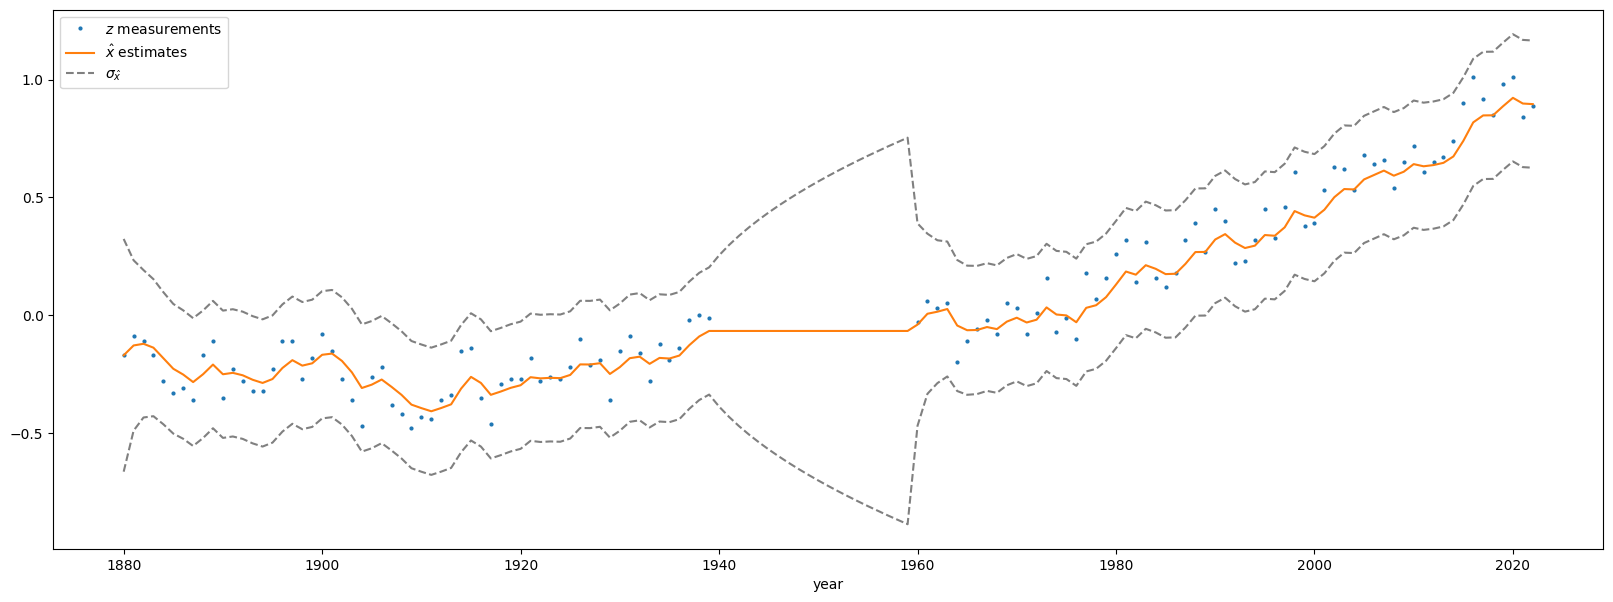

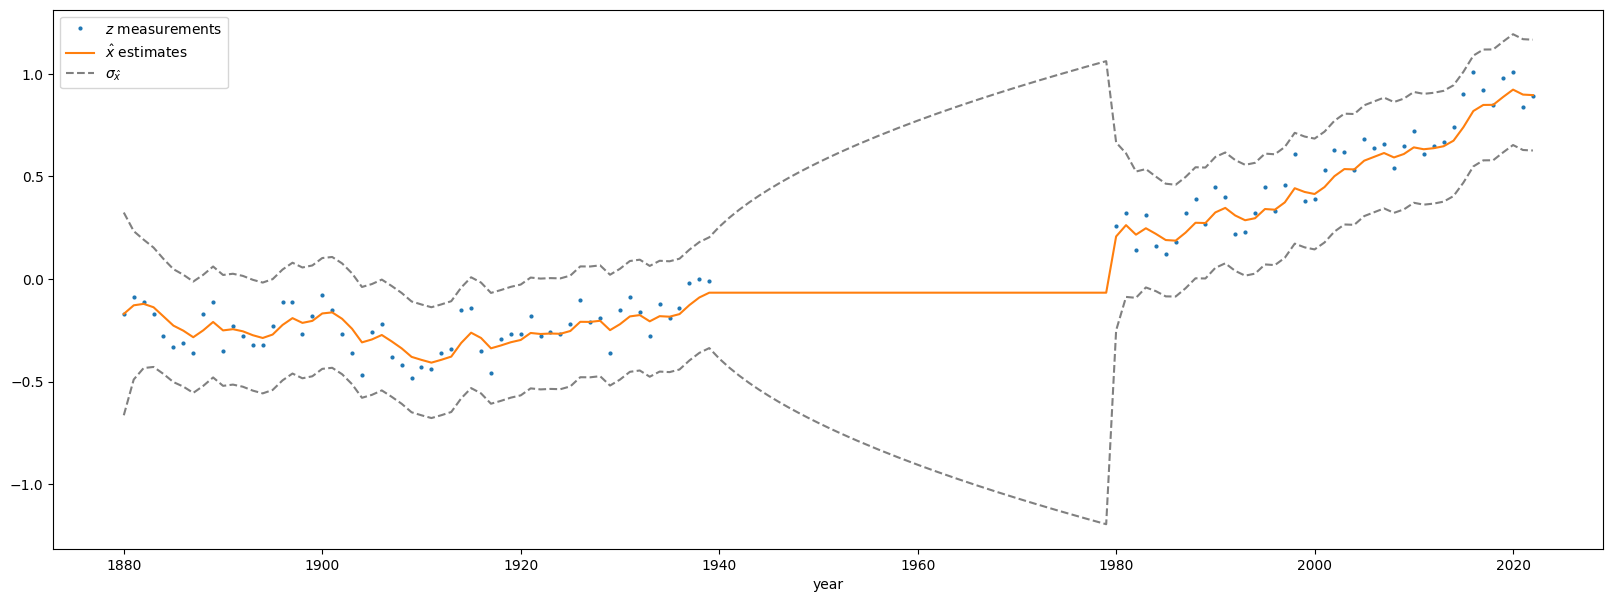

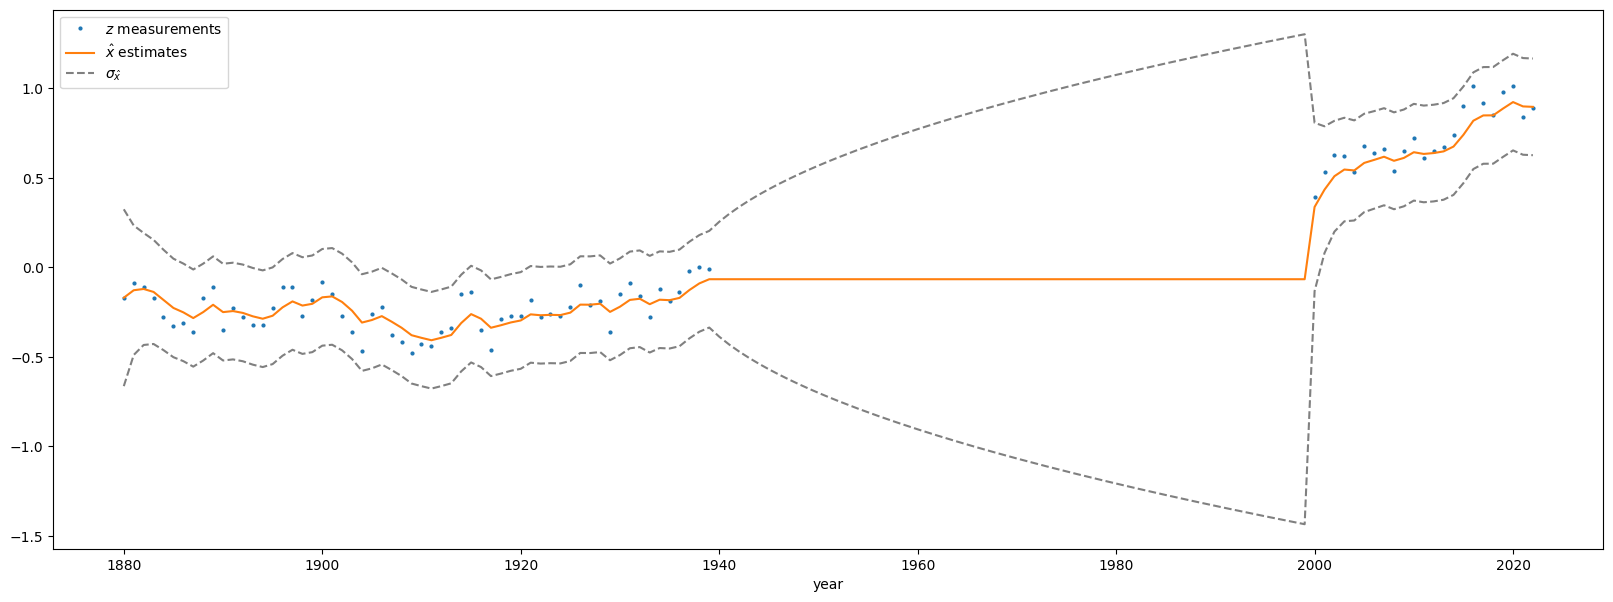

In [6]:
R = 0.25 # Measurement variance
Q = 0.03 # Process noise variance
zs = df.no_smoothing.to_numpy() # Measurements

for i in range(1,4):
    # Define an data gap interval
    start = 60 # Years beyond 1880
    end = start + 20*i
    gap_zs = np.copy(zs)
    gap_zs[start:end] = np.nan
    t = df.year.to_numpy()
    
    xs, Ps = kalman_1d(gap_zs, R, Q, P_0, x_0)
    plt.plot(t, gap_zs, marker='o', linestyle='none', markersize=2, label=r'$z$ measurements')
    plt.plot(t, xs, label=r'$\hat{x}$ estimates')
    plt.plot(t, xs + np.sqrt(Ps), linestyle='dashed', color='gray', label='$\sigma_{\hat{x}}$')
    plt.plot(t, xs - np.sqrt(Ps), linestyle='dashed', color='gray')
    plt.xlabel('year')
    plt.legend()
    plt.show()

__TODO__ The above gaps might look better if the process model assumed a constant velocity of the last velocity seen?

# Exploring the parameter space of $Q$ x $R$

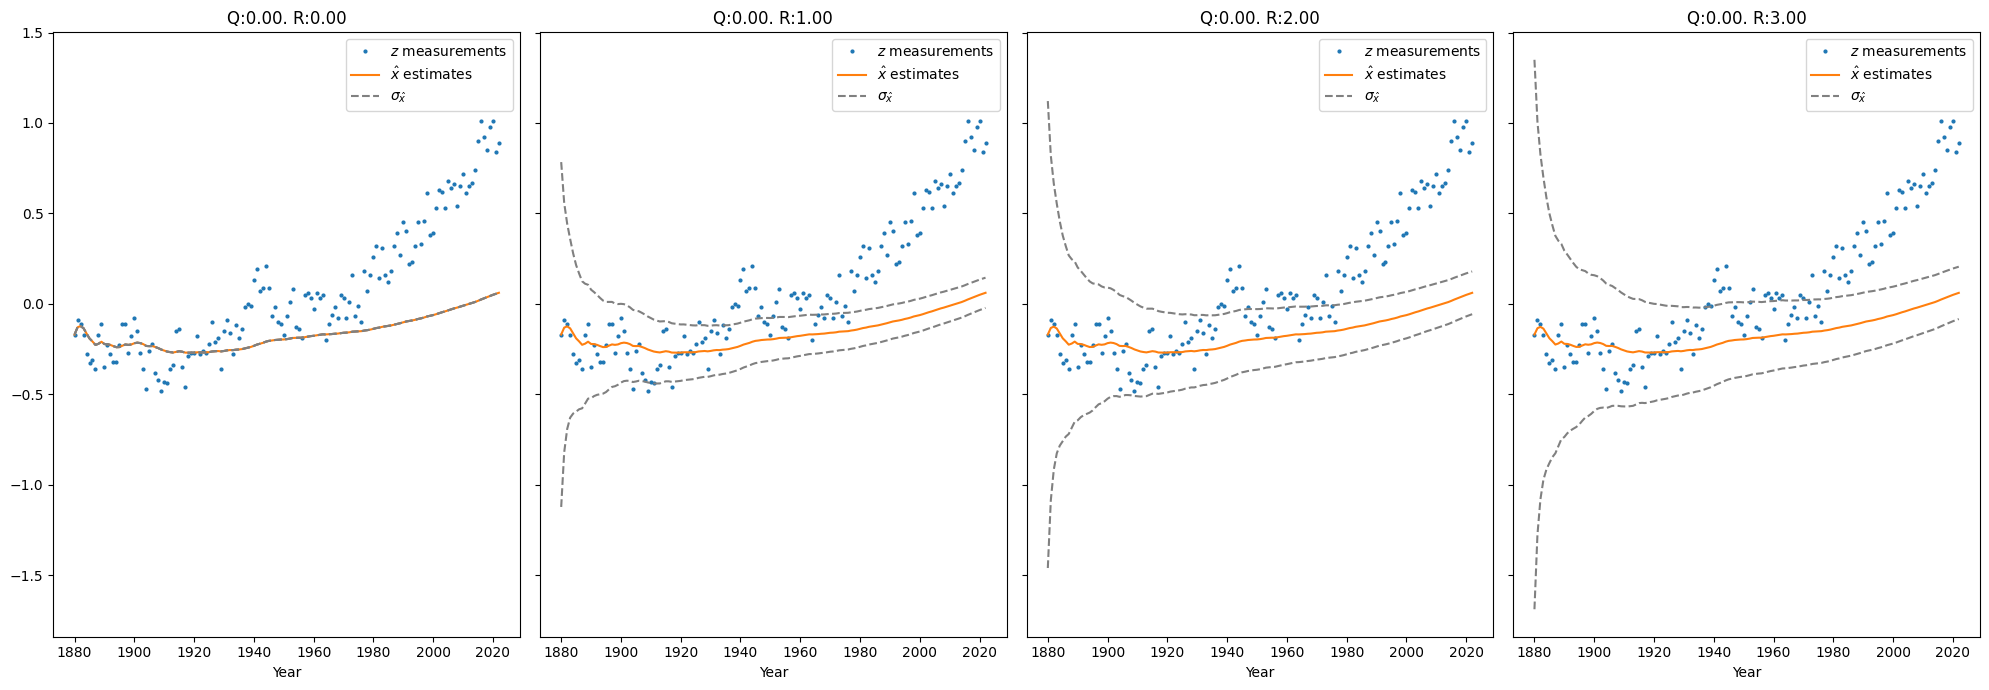

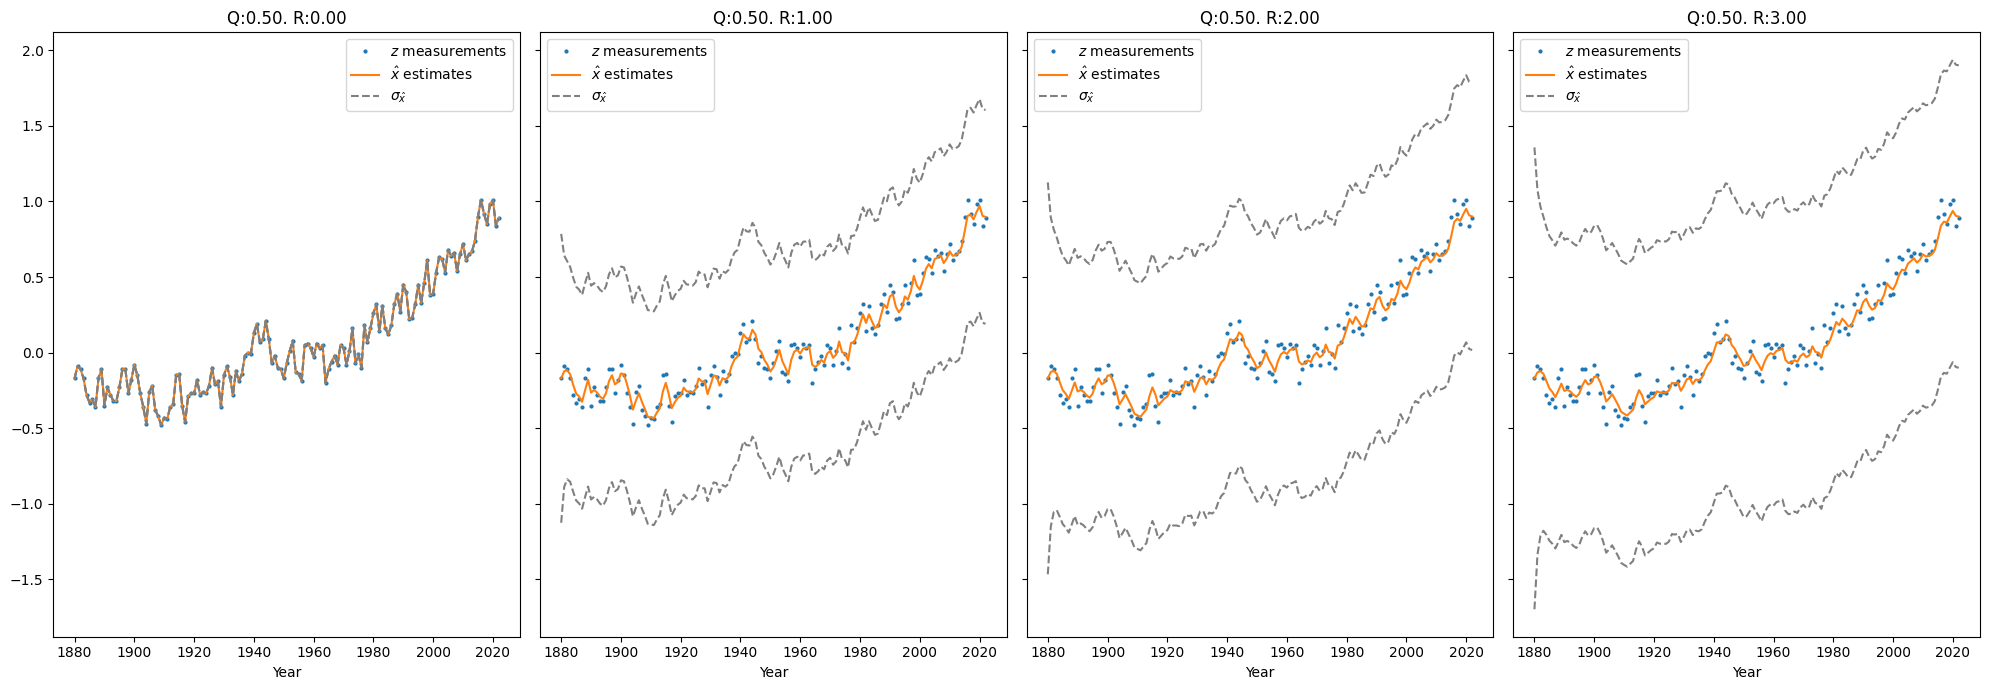

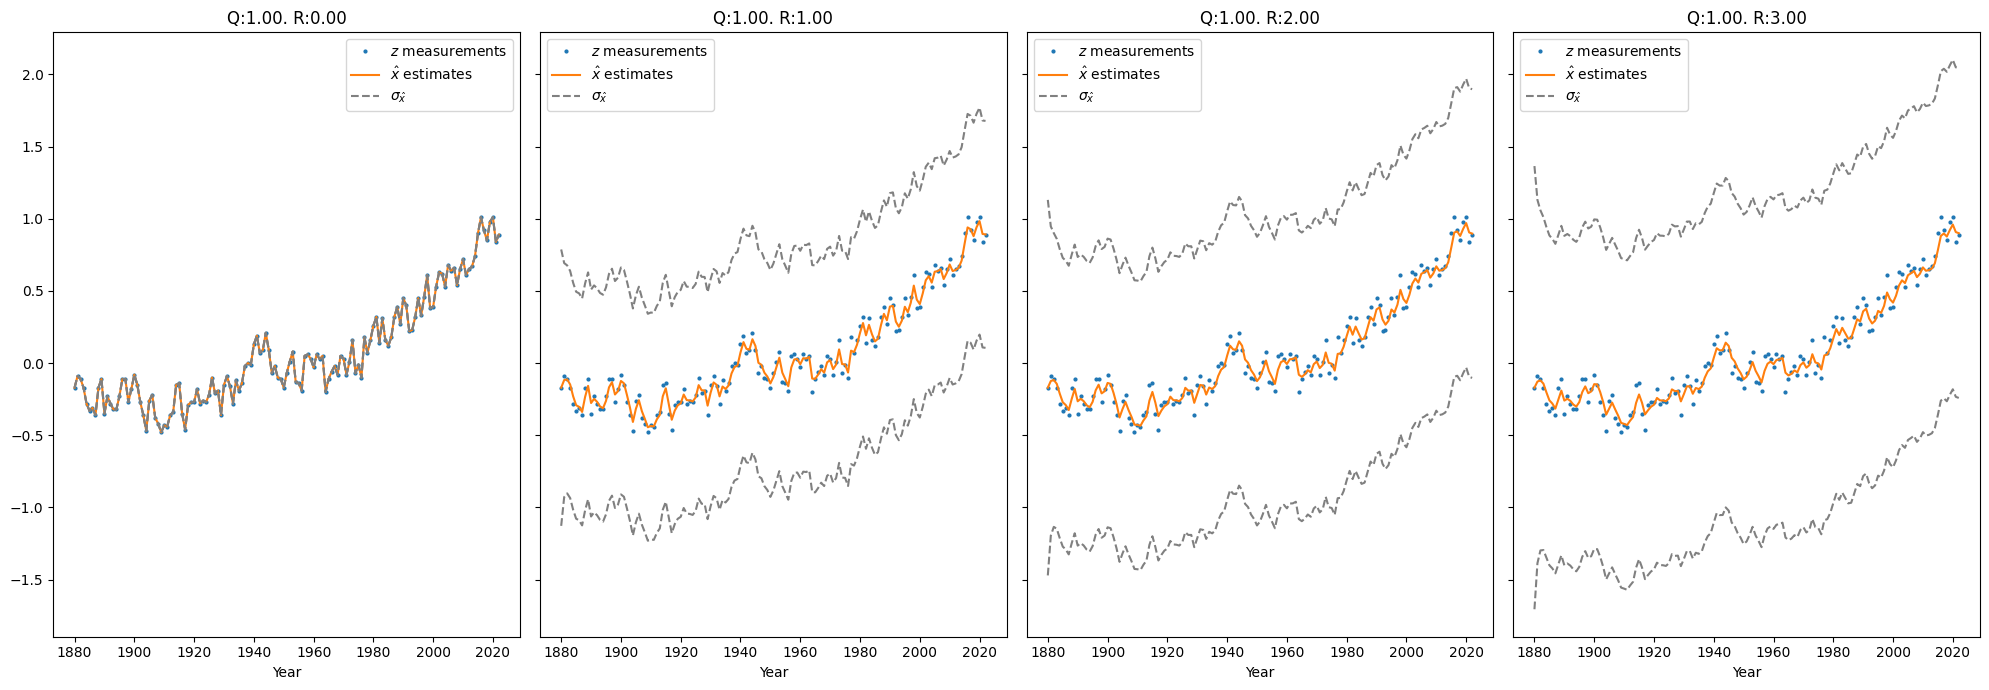

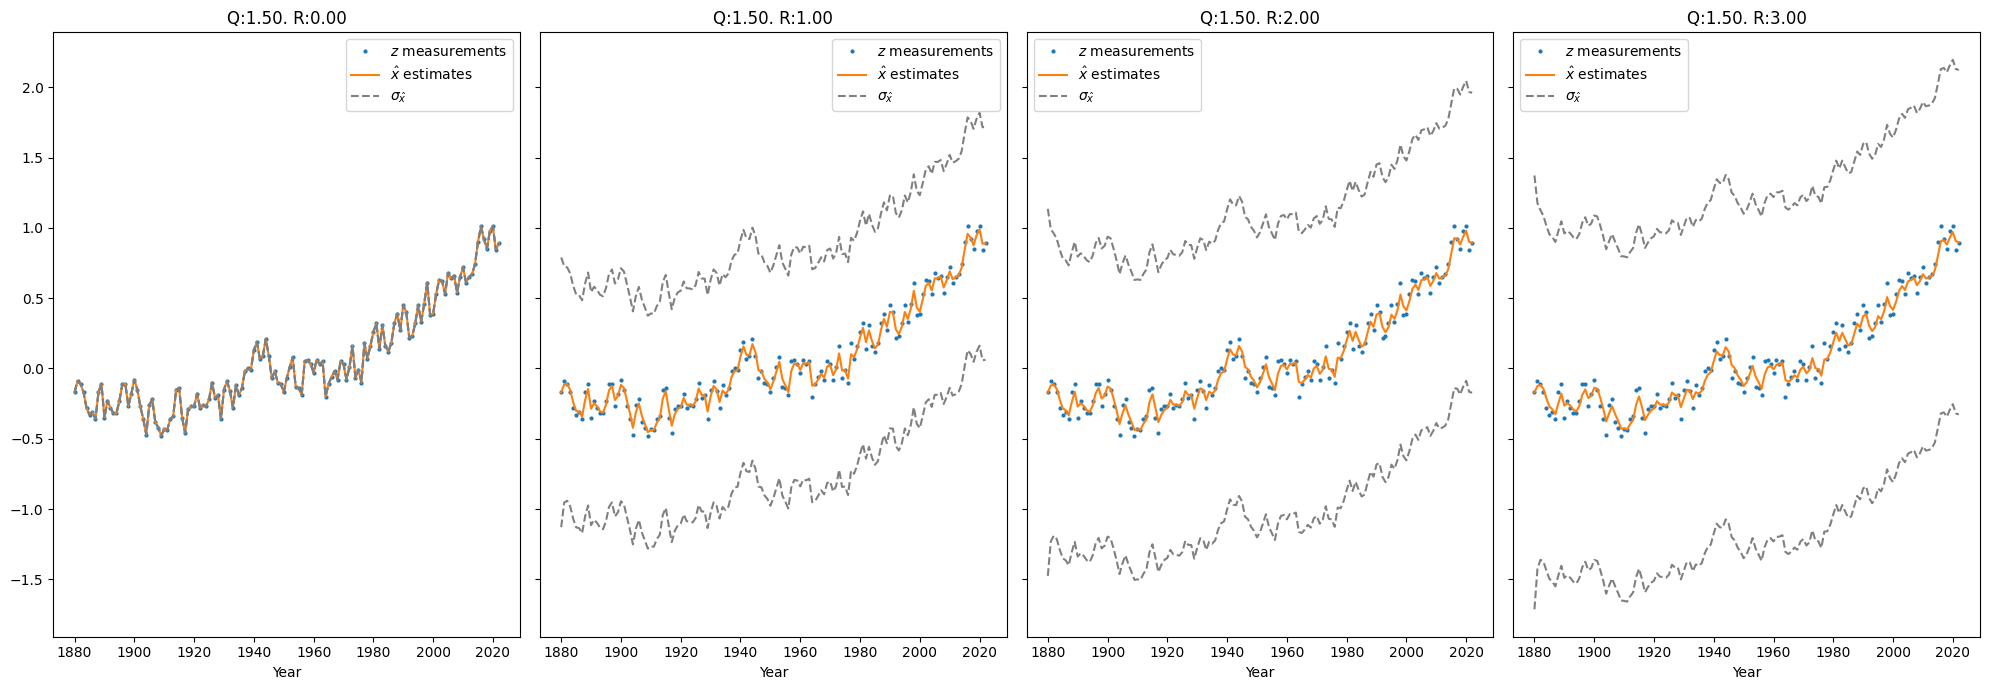

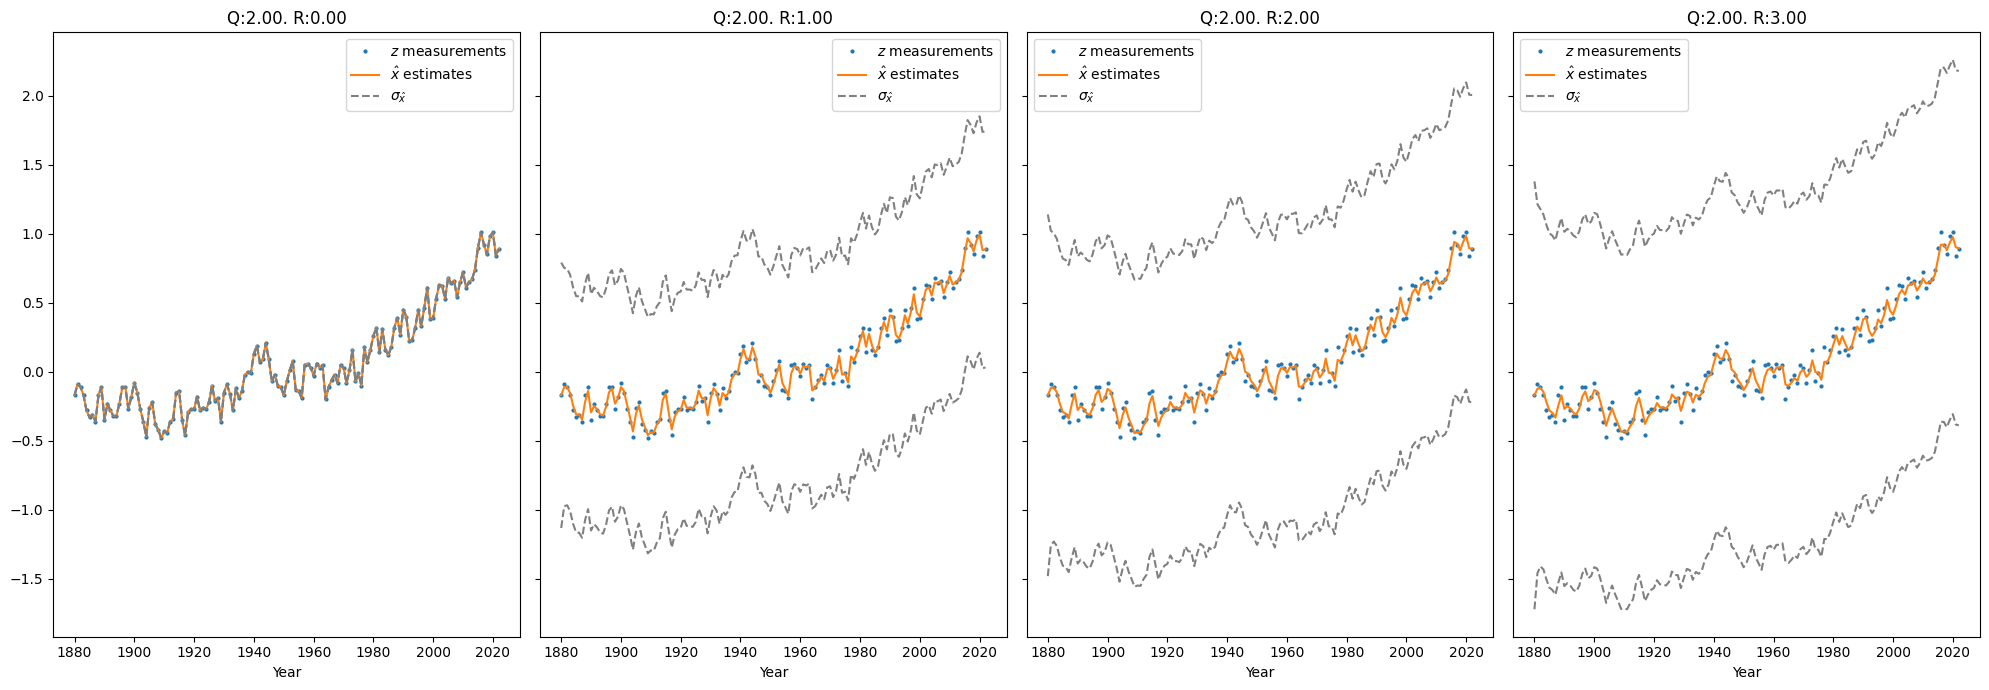

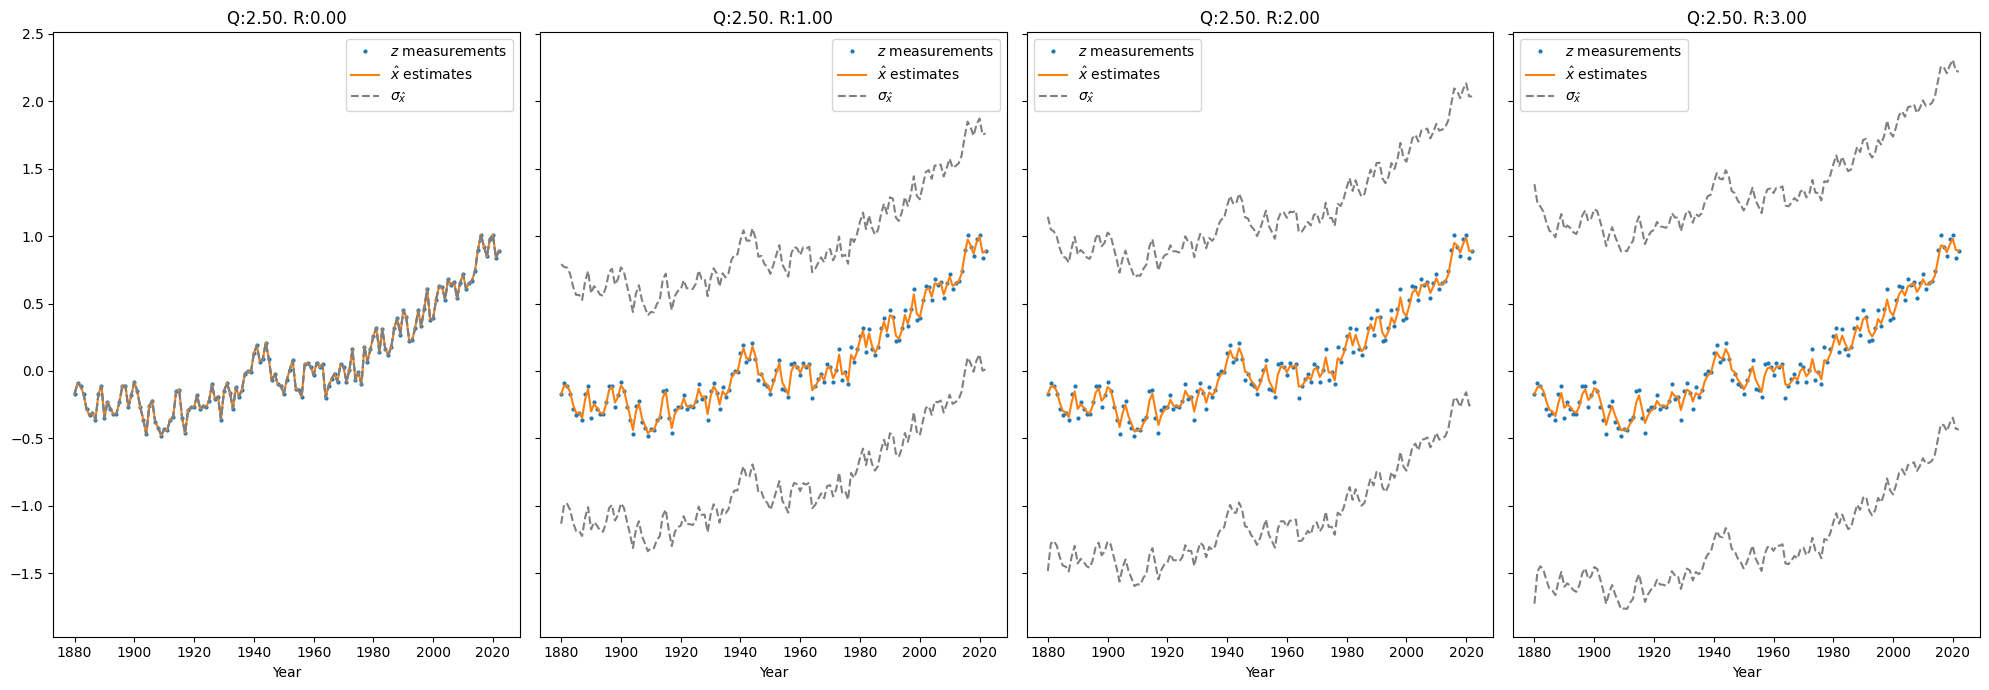

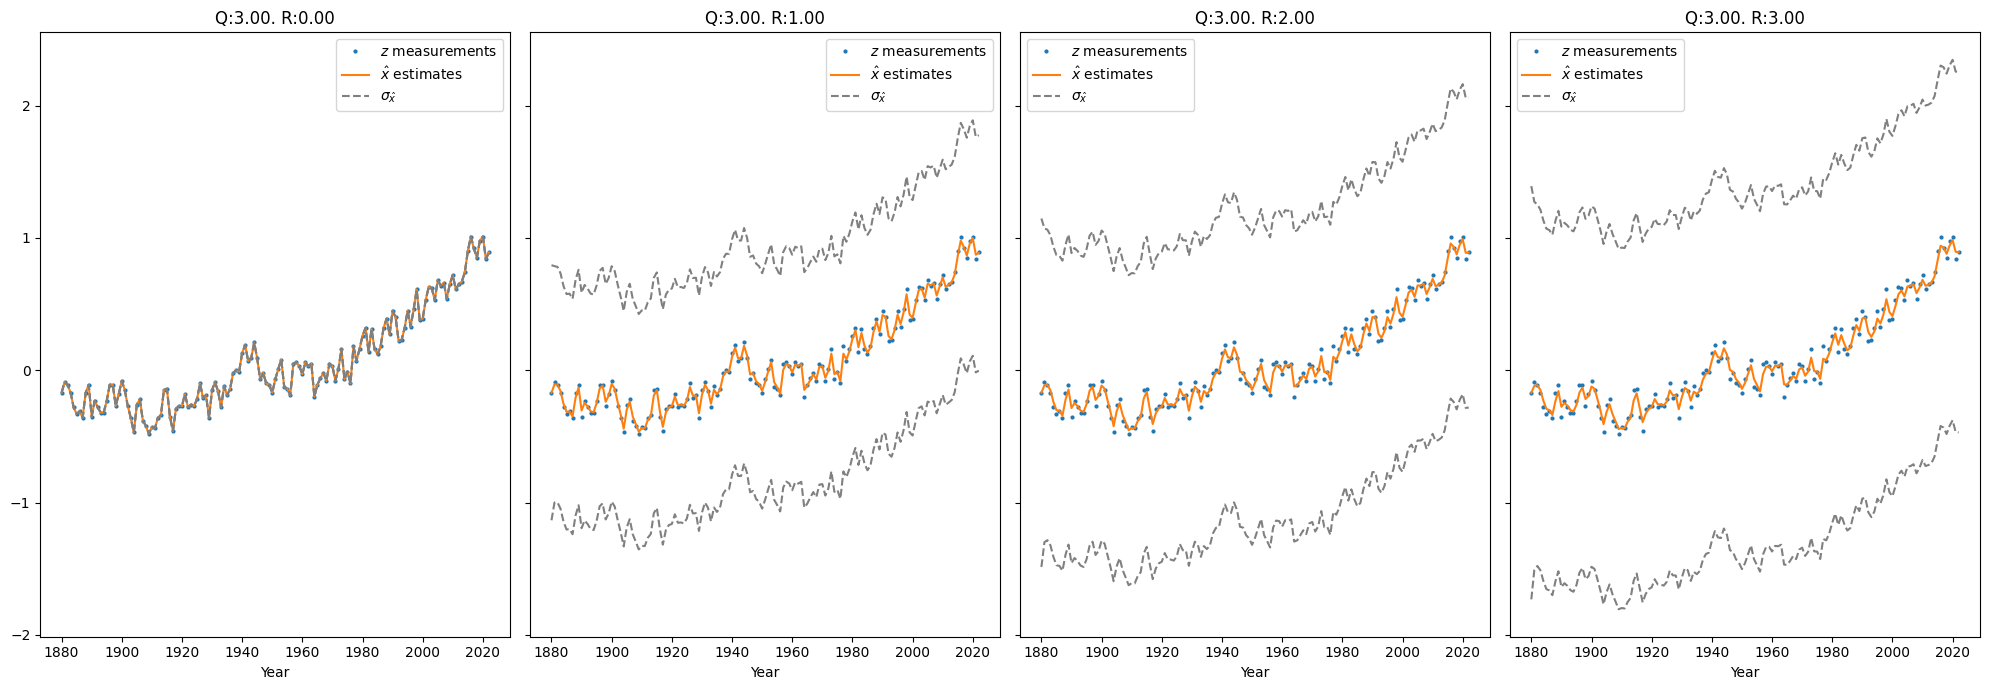

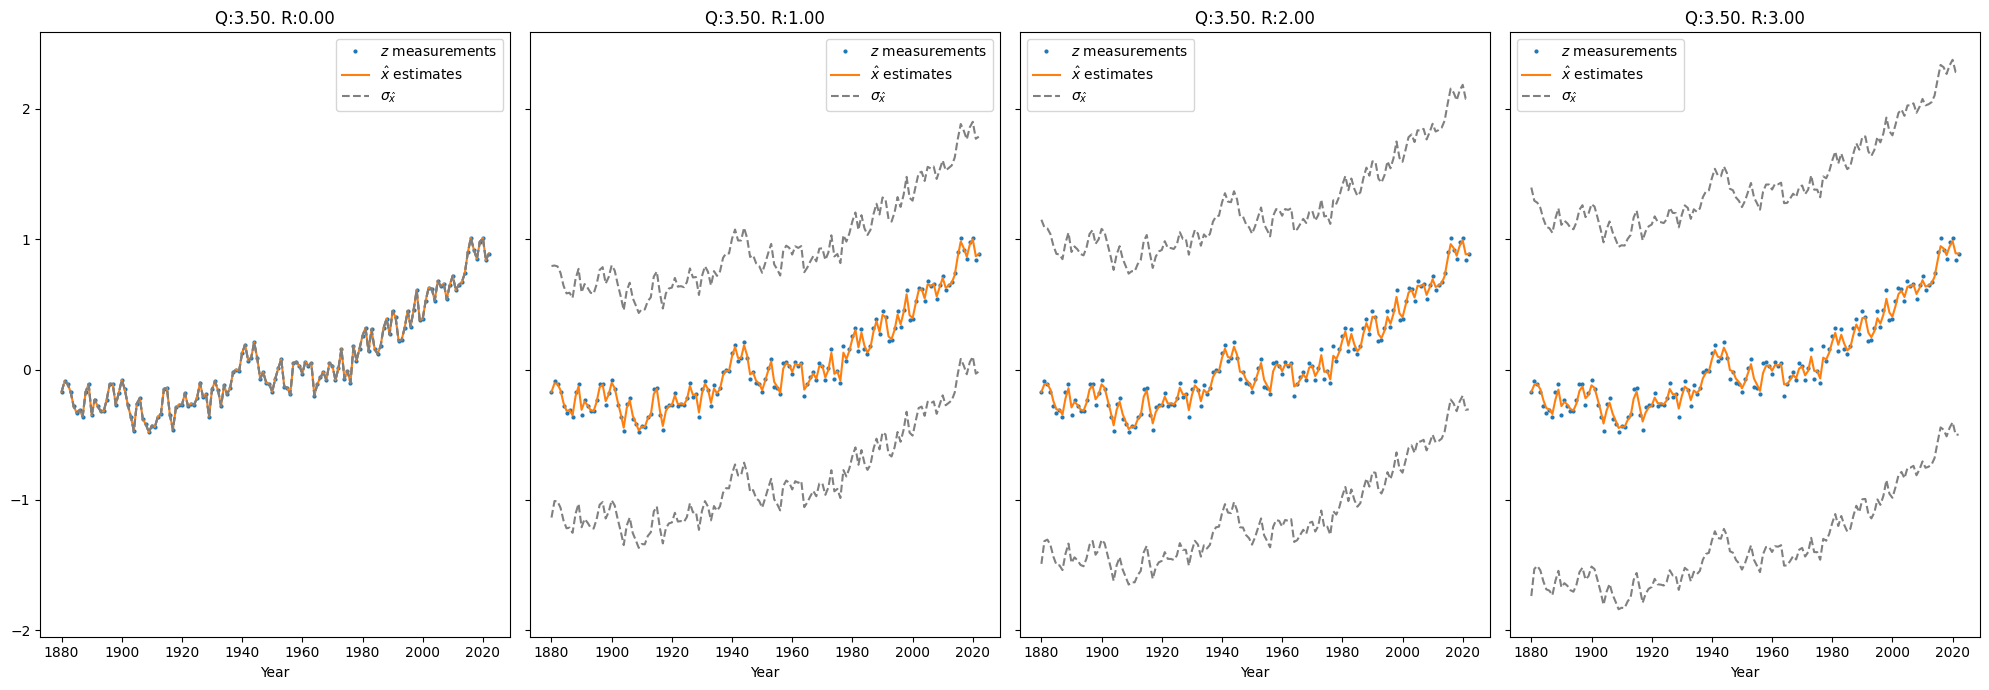

In [7]:
num_R_vals = 4
R_min = 10**-9
R_max = 4.0
for Q in np.arange(0.0, 4.0, 0.5): # Process noise variance values
    fig, axs = plt.subplots(nrows=1, ncols=num_R_vals, sharex=True, sharey=True) # TODO set figure sizes
    R_vals = np.arange(R_min, R_max, (R_max-R_min)/num_R_vals)
    
    for i, R in np.ndenumerate(R_vals): # Measurement noise variance values
        P_0 = 10
        x_0 = zs[0]
        xs, Ps = kalman_1d(zs, R, Q, P_0, x_0)
        axs[i].plot(df.year, zs, marker='o', linestyle='none', markersize=2, label=r'$z$ measurements')
        axs[i].plot(df.year, xs, label=r'$\hat{x}$ estimates')
        axs[i].plot(df.year, xs + np.sqrt(Ps), linestyle='dashed', color='gray', label='$\sigma_{\hat{x}}$')
        axs[i].plot(df.year, xs - np.sqrt(Ps), linestyle='dashed', color='gray')
        axs[i].set_title(f'Q:{Q:.02f}. R:{R:.02f}')
        axs[i].set_xlabel('Year')
        axs[i].legend()
    plt.tight_layout()
    plt.show()

# 2D Kalman for Process With Constant Acceleration

First lets create our deterministic process model

State: $\vec{x} = \begin{bmatrix} x & \dot{x} & \ddot{x} & y & \dot{y} & \ddot{y}\end{bmatrix}^T$

Constant acceleration: $\begin{bmatrix} \ddot{x} &  \ddot{y} \end{bmatrix}^T = \begin{bmatrix} 0 &  -9.81 \end{bmatrix}^T $

In [8]:
# Simulation config

# Timestep
dt = 0.1

# Number of seconds of simulation
T = 5
N = T / dt
assert N.is_integer()
N = int(N)

print(f'Simulating {T:.02f} seconds. {N} timesteps')

Simulating 5.00 seconds. 50 timesteps


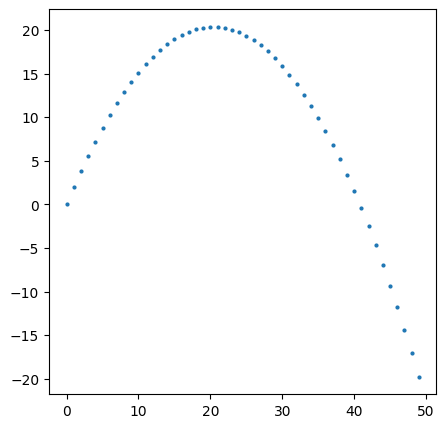

In [9]:
# Initial position
x_0, y_0 = [0., 0]

# Initial velocity
vx_0, vy_0 = [10., 20]

# Constant acceleration
ax_0, ay_0 = [0, -9.81]

# Initial state
n = 6 # State dimensionality
x0 = np.array([x_0, vx_0, ax_0, y_0, vy_0, ay_0])

# Transition matrix
F = np.array([
    [1., dt, 0.5*dt**2, 0, 0, 0],
    [0, 1, dt, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, dt, 0.5*dt**2],
    [0, 0, 0, 0, 1, dt], 
    [0, 0, 0, 0, 0, 1],
])

# Results matrix. Each row is the state for one timestep
xs = np.full((N, n), np.nan)
xs[0,:] = x0

for k in range(1, N):
    xs[k, :] = F @ xs[k-1, :]
    
plt.rcParams["figure.figsize"] = (5,5)
plt.plot(xs[:,0], xs[:,3], marker='o', linestyle='none', markersize=2)
plt.show()

Now lets add __noise__ to the process:

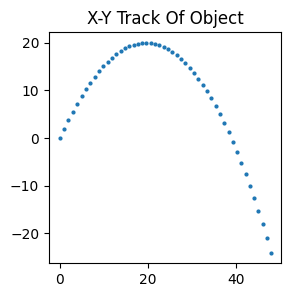

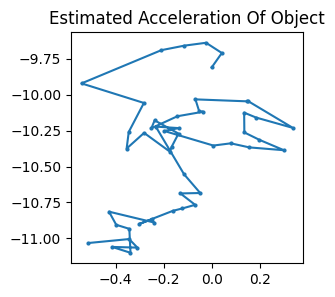

In [10]:
# Approximate Q as only variance for the acceleration components ax and ay.
accel_var = 0.015
Q_true = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, accel_var, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, accel_var],
])

# Results matrix. Each row is the state for one timestep
true_xs = np.full((N, 6), np.nan)
true_xs[0,:] = x0

for k in range(1, N):
    # Process noise - only affects acceleration
    eta = rng.multivariate_normal(np.zeros(n), Q_true)
    
    true_xs[k, :] = F @ true_xs[k-1, :] + eta
    
    # PROBLEM: This is accumulating the acceleration noise over each step.
    # I want it to vary around the constant acceleration value.
    # Should acceleration at the next step be a0 + eta?
    
plt.rcParams["figure.figsize"] = (3,3)
plt.plot(true_xs[:,0], true_xs[:,3], marker='o', linestyle='none', markersize=2)
plt.title('X-Y Track Of Object')
plt.show()

plt.plot(true_xs[:,2], true_xs[:,5], marker='o', markersize=2)
plt.title('Estimated Acceleration Of Object')
plt.show()

__TODO/Question__: Notice the above estimated acceleration state is a brownian walk. i.e. cumulative. I'm unsure if that's correct. Intuitively I thought it would bounce around a mean of $\vec{a}= [0, -9.8]^T$, but over a long time this would result in acceleration that is pretty far off from that of gravity. That can't be the right model... can it?

- Maybe it can. The the Labbe [Designing Kalman Filters](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/08-Designing-Kalman-Filters.ipynb) section discussing filter orders, he does exactly that in his analogous 2nd order filter.
- TODO: See [kalman filter tutorial example](https://www.kalmanfilter.net/multiExamples.html), in which the acceleration is moved into the control term, and only position and velocity are tracked in state (first order filter?).

Also keep in mind: 
- The difference between the actual process noise (eg what we use to create the synthetic process series), and the process noise we tell the Kalman filter (which is more a degree of weight to give the predictions vs measurements).
- The true velocity and acceleration components of the synthesized track are values of the hidden variables (assuming we only have a position sensor)

# Multidimensional linear kalman filter

Estimate covariance $P$:

$
P = \begin{bmatrix}
\sigma_{x}^2 & \sigma_{x,\dot{x}}^2 & \sigma_{x,\ddot{x}}^2 & \sigma_{x,y}^2 & \sigma_{x,\dot{y}}^2 & \sigma_{x,\ddot{y}}^2  \\
\sigma_{\dot{x},x}^2 & \sigma_{\dot{x}}^2 & \sigma_{\dot{x},\ddot{x}}^2 & \sigma_{\dot{x},y}^2 & \sigma_{\dot{x},\dot{y}}^2 & \sigma_{\dot{x},\ddot{y}}^2  \\
\sigma_{\ddot{x},x}^2 & \sigma_{\ddot{x},\dot{x}}^2 & \sigma_{\ddot{x}}^2 & \sigma_{\ddot{x},y}^2 & \sigma_{\ddot{x},\dot{y}}^2 & \sigma_{\ddot{x},\ddot{y}}^2  \\
\sigma_{y,x}^2 & \sigma_{y,\dot{x}}^2 & \sigma_{y,\ddot{x}}^2 & \sigma_{y}^2 & \sigma_{y,\dot{y}}^2 & \sigma_{y,\ddot{y}}^2  \\
\sigma_{\dot{y},x}^2 & \sigma_{\dot{y},\dot{x}}^2 & \sigma_{\dot{y},\ddot{x}}^2 & \sigma_{\dot{y},y}^2 & \sigma_{\dot{y}}^2 & \sigma_{\dot{y},\ddot{y}}^2  \\
\sigma_{\ddot{y},x}^2 & \sigma_{\ddot{y},\dot{x}}^2 & \sigma_{\ddot{y},\ddot{x}}^2 & \sigma_{\ddot{y},y}^2 & \sigma_{\ddot{y},\dot{y}}^2 & \sigma_{\ddot{y}}^2 
\end{bmatrix}
$

## Synthesizing measurements

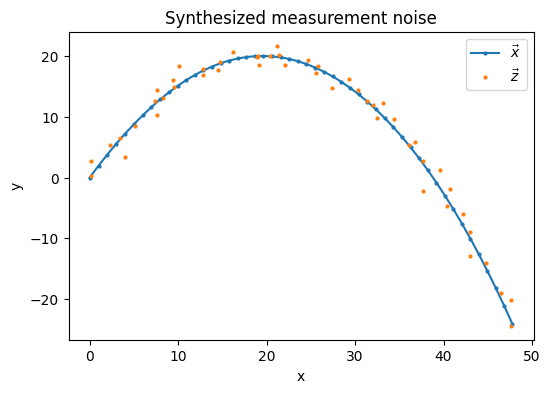

In [11]:
# Synthesize measurements by adding random noise to the true position series
z_var = 1.2
# Measurement (position) noise covariance matrix (independent bivariate normal)
R_true = np.array([
    [z_var, 0],
    [0, z_var],
])
zs = np.full((N, 2), np.nan)
zs[:, 0] = true_xs[:, 0] # x positions
zs[:, 1] = true_xs[:, 3] # y positions

zs = zs + rng.multivariate_normal(np.zeros(2), R_true, N)

plt.rcParams["figure.figsize"] = (6,4)
plt.plot(true_xs[:,0], true_xs[:,3], label=r'$\vec{x}$',  marker='o', markersize=2)
plt.plot(zs[:,0], zs[:,1], label=r'$\vec{z}$', marker='o', linestyle='none', markersize=2)
plt.title('Synthesized measurement noise')
plt.xlabel('x'); plt.ylabel('y')
plt.legend()
plt.show()

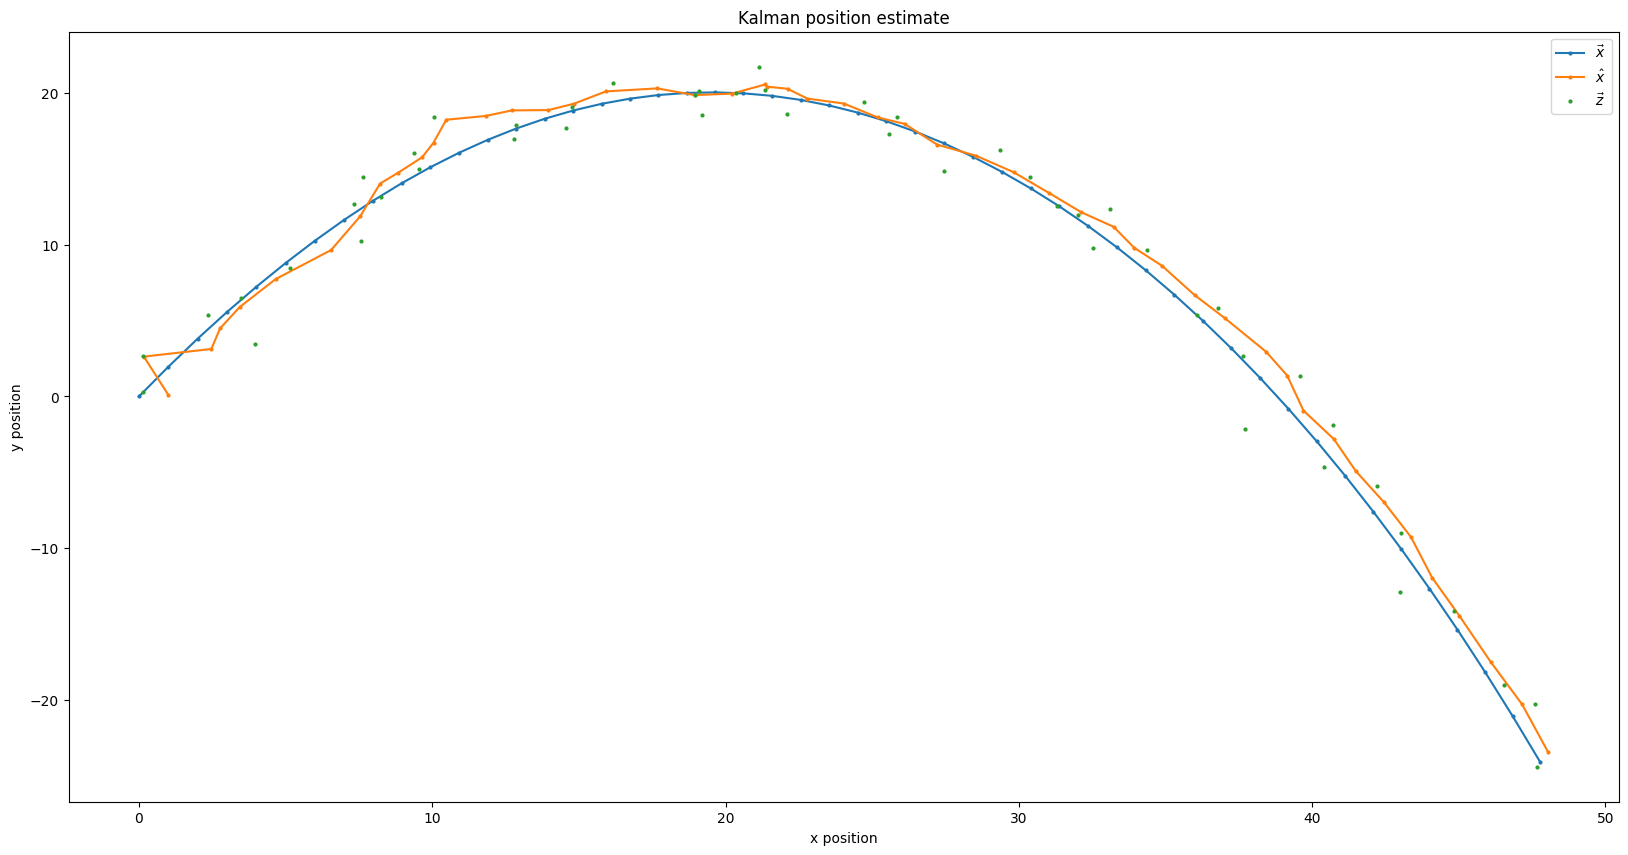

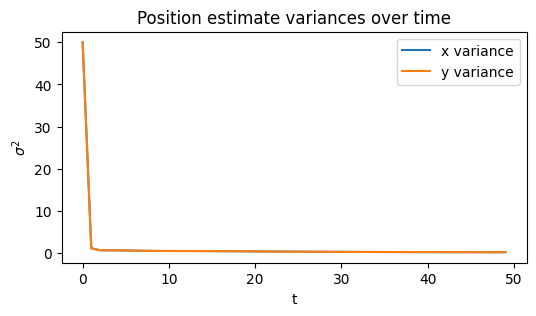

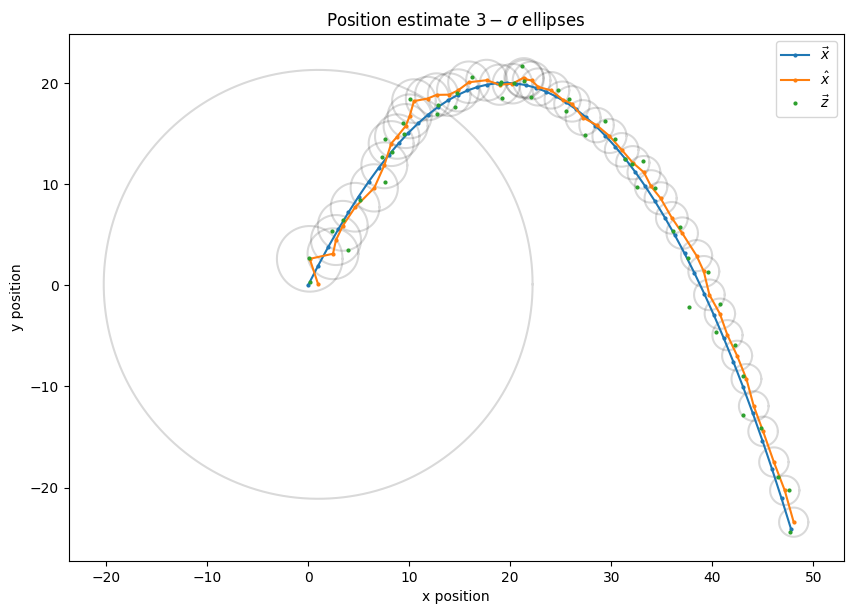

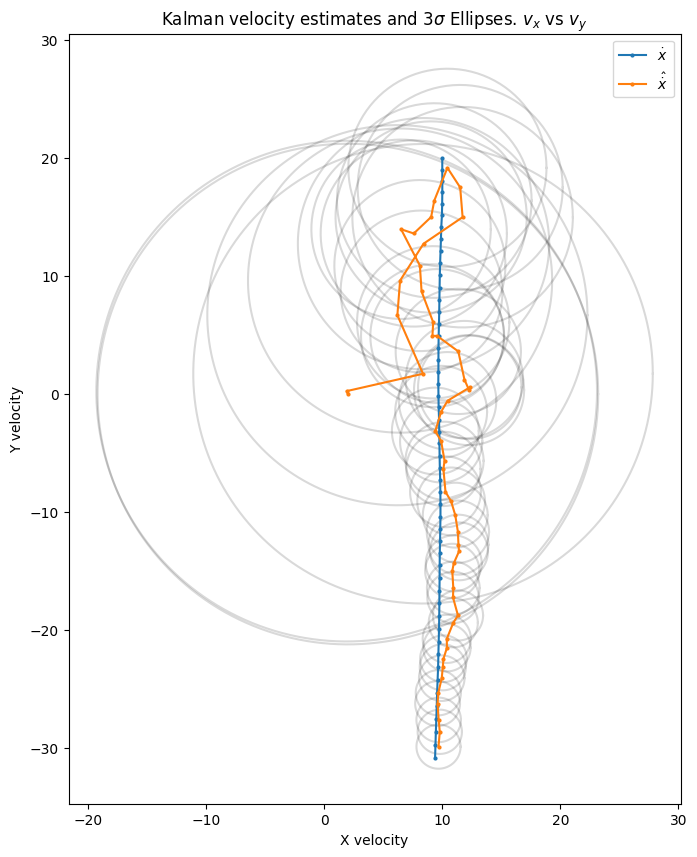

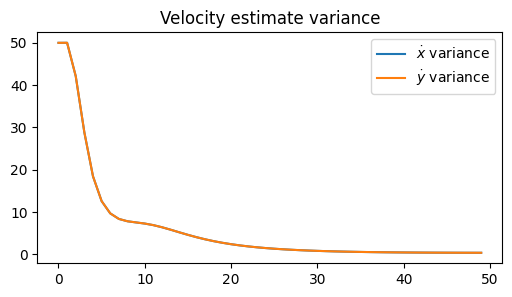

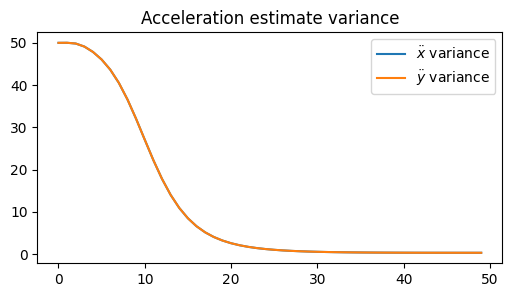

In [12]:
# Matrix H converts state vectors into measurement space
# In this model, that means grabbing the position values
H = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
])

def kalman_6d(zs, R, Q, x_0, P_0):
    assert len(zs) == N
    # Store filter estimates (means and variances)
    xs = np.full((N, 6), np.nan)
    Ps = np.full((N, 6, 6), np.nan)
    
    # Initial estimate
    xs[0,:] = x_0
    Ps[0] = P_0
    
    x = np.copy(x_0)
    P = np.copy(P_0)

    # TODO: Should we exclude prediction calculation for first iteration?
    # But we still want to do the correction for the first iteration, right?
    for k in range(1, N):
        # 1) PREDICT
        prior = F @ xs[k-1,:]
        P = F @ P @ F.T + Q

        # 2) UPDATE
        # TODO: Currently using Labbe notation. Switch to Young?

        # Calculate system uncertainty
        S = H @ P @ H.T + R

        # Calculate kalman gain
        K = P @ H.T @ np.linalg.inv(S)

        # Calculate residual: Difference between prediction an measurement
        # (In measurement space)
        y = zs[k] - H @ prior

        # Caculate posterior state (corrected estimate and covar)
        post = prior + K @ y
        P = P - K @ H @ P

        # Save
        xs[k] = post
        Ps[k] = P
        
    return xs, Ps

# TODO: Known bug. When R and Q are zero matrices, the value of S's elements get tiny (floating
# point errors representing zero), which leads inv(S) to produce a matrix of nans. This produces
# nan estimates from that iteration onwards. Not sure how to avoid, but a workaround is to not pass
# in Q and R made of all zeros.

# Initialize filter state
# Guess the position somewhat accurately, leave the velocity and acceleration state guesses as 0
x_0 = np.array([1, 2, 0, 0.1, 0, 0])
P_0 = np.eye(6) * 50 # Start with very low confidence in predictions

# Assume we can configure the system's process and measurement noise params correctly
Q = Q_true
R = R_true

xs, Ps = kalman_6d(zs, R, Q, x_0, P_0)
    
# Extract covariances for position, velocity, and acceleration
pos_vars, vel_vars, acc_vars = utils.separate_covar_series(Ps)
    
# Plot track, measurements, and estimate for position
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(true_xs[:,0], true_xs[:,3], label=r'$\vec{x}$',  marker='o', markersize=2)
plt.plot(xs[:,0], xs[:,3], label=r'$\hat{x}$',  marker='o', markersize=2)
plt.plot(zs[:,0], zs[:,1], label=r'$\vec{z}$', marker='o', linestyle='none', markersize=2)
plt.title('Kalman position estimate')
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend()
plt.show()

# Plot positional variance
plt.rcParams["figure.figsize"] = (6,3)
plt.plot(np.arange(0,N), pos_vars[:,0,0], label='x variance')
plt.plot(np.arange(0,N), pos_vars[:,1,1], label='y variance')
plt.title('Position estimate variances over time')
plt.xlabel('t')
plt.ylabel(r'$\sigma^2$')
plt.legend()
plt.show()

# Plot positional estimates with 3sigma ellipses
figure, axes = plt.subplots(1, figsize=(10,10)) 
axes.set_aspect(1) 
# Plot prediction 3-sigma elipses
for i in range(len(vel_vars)):
    pos_var = pos_vars[i]
    mu = np.array([xs[i,0], xs[i,3]])
    utils.plot_covar_ellipse(pos_var, mu, alpha=0.15)
plt.plot(true_xs[:,0], true_xs[:,3], label=r'$\vec{x}$',  marker='o', markersize=2)
plt.plot(xs[:,0], xs[:,3], label=r'$\hat{x}$',  marker='o', markersize=2)
plt.plot(zs[:,0], zs[:,1], label=r'$\vec{z}$', marker='o', linestyle='none', markersize=2)
plt.title(r'Position estimate $3-\sigma$ ellipses')
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend()
plt.show()

# Plot velocity estimates
figure, axes = plt.subplots(1, figsize=(10,10)) 
axes.set_aspect(1) 
# Plot prediction 3-sigma elipses
for i in range(len(vel_vars)):
    vel_var = vel_vars[i]
    mu = np.array([xs[i,1], xs[i,4]])
    utils.plot_covar_ellipse(vel_var, mu, alpha=0.15)
# Plot track and estimates
plt.plot(true_xs[:,1], true_xs[:,4], label=r'$\dot{x}$',  marker='o', markersize=2)
plt.plot(xs[:,1], xs[:,4], label=r'$\hat{\dot{x}}$',  marker='o', markersize=2)
plt.title(r'Kalman velocity estimates and $3\sigma$ Ellipses. $v_x$ vs $v_y$')
plt.xlabel('X velocity')
plt.ylabel('Y velocity')
plt.legend()
plt.show()

# Plot velocity variances
plt.rcParams["figure.figsize"] = (6,3)
plt.plot(np.arange(0,N), vel_vars[:,0,0], label=r'$\dot{x}$ variance')
plt.plot(np.arange(0,N), vel_vars[:,1,1], label=r'$\dot{y}$ variance')
plt.title('Velocity estimate variance')
plt.legend()
plt.show()

# Plot acceleratioin variances
plt.rcParams["figure.figsize"] = (6,3)
plt.plot(np.arange(0,N), acc_vars[:,0,0], label=r'$\ddot{x}$ variance')
plt.plot(np.arange(0,N), acc_vars[:,1,1], label=r'$\ddot{y}$ variance')
plt.title('Acceleration estimate variance')
plt.legend()
plt.show()

# TODO could plot x and y pos, vel, and acc as functions of t.
# TODO Plot x(t) and vel_x(t) slopes overlaid

# Do the true positions $\vec{x}(k)$ fall within the $\hat{x}(k)$ estimates' $3\sigma$ confidence ellipses?

__TODO__ Organization: Move this into the section discussing accuracy of the filter.

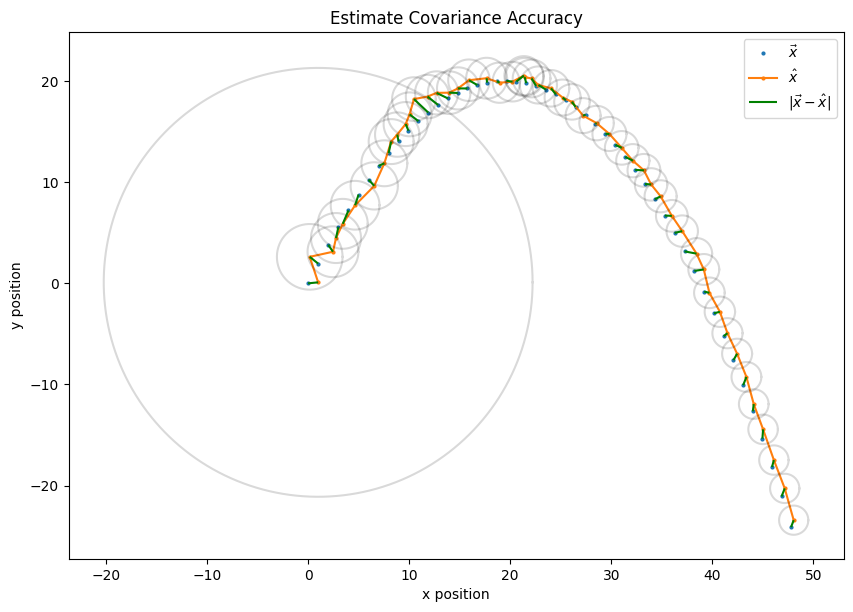

Percent of estimate covar ellipse containing true state: 100.00%
R:
[[1.2 0. ]
 [0.  1.2]]
Q:
[[0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.015 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.015]]


In [13]:
# Return a boolean array, where each element encodes whether the k-th true
# state is within n-std confidence ellipse of the k-th estimate.
# Only works for 2D state
def within_confidence_ellipse(true_xs, xs, Ps, n_std=3.0):
    """
        Args: 
            xs: State estimate array
            true_xs: True state array
            Ps: Estimate covariance array
            n_std: Number of standard deviations defining the covar ellipse size
    """
    assert len(xs) == N
    assert len(xs[0]) == 2
    assert Ps[0].shape == (2,2)
    
    result = np.zeros(N, dtype=bool)
    for k in range(N):
        result[k] = utils.ellipse_contains(true_xs[k], xs[k], Ps[k], n_std=n_std)
    return result

# Visualize the accuracy of 2D state estimates as whether their 2x2 covariance ellipses
# contain the true state values.
def plot_estimate_covar_accuracy(true_xs, xs, Ps, n_std=3.0, xlabel='', ylabel='', figsize=(10,10)):
    # Plot positional estimates with 3sigma ellipses
    fig, ax = plt.subplots(1, figsize=figsize) 
    ax.set_aspect(1) 

    # Plot estimated and true state
    plt.plot(true_xs[:,0], true_xs[:,1], label=r'$\vec{x}$',  marker='o', markersize=2, linestyle='none')
    plt.plot(xs[:,0], xs[:,1], label=r'$\hat{x}$',  marker='o', markersize=2)

    # Plot prediction 3-sigma elipses
    for k in range(N):
        #mu = np.array([xs[k,0], xs[k,3]])
        utils.plot_covar_ellipse(Ps[k], xs[k], alpha=0.15)

    # Calculate whether k-th true value falls within k-th estimates ellipse
    accurate_ellipses = within_confidence_ellipse(true_xs, xs, Ps, n_std=3.0)

    # TODO separate visualization logic into a function

    # Plot line segments connecting each estimate to its true value for time k
    line_segs = []
    for k in range(N):
        line_segs.append([xs[k], true_xs[k]])

    # Color line segments based on the estimate accuracy
    colors = np.where(accurate_ellipses, 'green', 'red')

    lc = mc.LineCollection(line_segs, linewidths=1.5, linestyle='solid', colors=colors, label=r'$|\vec{x}-\hat{x}|$')
    ax.add_collection(lc)

    plt.title('Estimate Covariance Accuracy')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
    print(f'Percent of estimate covar ellipse containing true state: {np.sum(accurate_ellipses)*100/N:.02f}%')
    
# Demonstrate with x-y position state estimates
x_0 = np.array([1, 2, 0, 0.1, 0, 0])
P_0 = np.eye(6) * 50 # Start with very low confidence in predictions
Q = Q_true
R = R_true

xs, Ps = kalman_6d(zs, R, Q, x_0, P_0)
xs_pos, _, _ = utils.separate_state_series(xs)
true_xs_pos, _, _ = utils.separate_state_series(true_xs)
Ps_pos, _, _ = utils.separate_covar_series(Ps)

plot_estimate_covar_accuracy(true_xs_pos, xs_pos, Ps_pos, n_std=3.0, 
                             xlabel='x position', ylabel='y position')

print(f'R:\n{R}\nQ:\n{Q}')

## Exploring covariance of position with velocity

TODO: Graph $\sigma_{x,\dot{x}}^2$ and $\sigma_{y,\dot{y}}^2$ for first few timesteps.

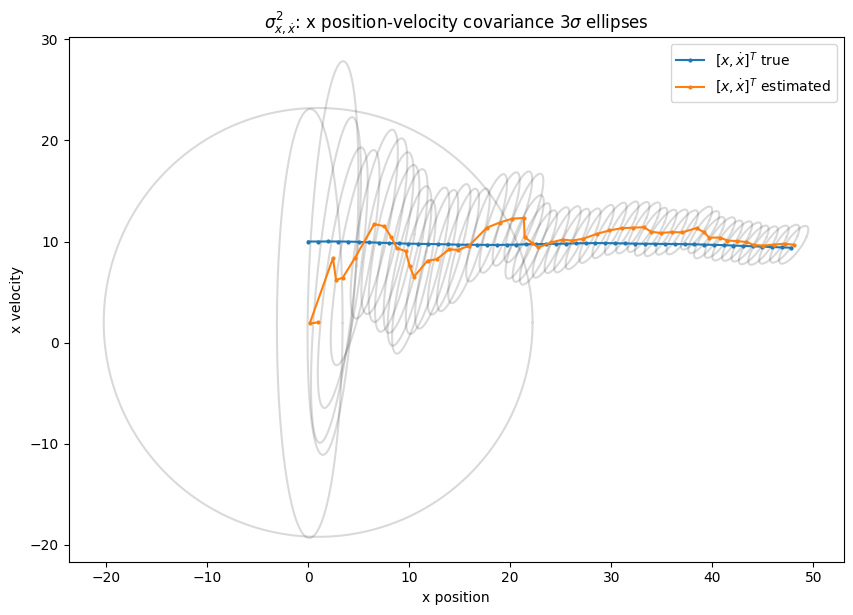

In [14]:
# Extract pos-vel covariance in the x dimension
pos_vel_x_vars = np.full((N, 2, 2), np.nan)
for i in range(len(Ps)):
    P = Ps[i]
    pos_vel_x_vars[i] = np.array([[P[0,0], P[0,1]],[P[1,0], P[1,1]]])

# Plot
figure, axes = plt.subplots(1, figsize=(10,10)) 
axes.set_aspect(1) 
# Plot prediction 3-sigma covariance elipses
for i in range(len(pos_vel_x_vars)):
    S = pos_vel_x_vars[i]
    mu = np.array([xs[i,0], xs[i,1]])
    utils.plot_covar_ellipse(S, mu, alpha=0.15)
plt.plot(true_xs[:,0], true_xs[:,1], label=r'$[x,\dot{x}]^T$ true',  marker='o', markersize=2)
plt.plot(xs[:,0], xs[:,1], label=r'$[x,\dot{x}]^T$ estimated',  marker='o', markersize=2)
#plt.plot(zs[:,0], zs[:,1], label=r'$\vec{z}$', marker='o', linestyle='none', markersize=2)
plt.title(r'$\sigma_{x,\dot{x}}^2$: x position-velocity covariance $3\sigma$ ellipses')
plt.xlabel('x position')
plt.ylabel('x velocity')
plt.legend()
plt.show()

Notes: Above displays how the filter learns the covariance between position and the hidden variable velocity over time. It starts with prediction uncertainty as a wide variance fully uncorrelated (circular) ellipse, then converges over time to the way it looks in the end: with a positive covariance between position and velocity.

__TODO__ We could expand this to show $\sigma_{y,\dot{y}}^2$, $\sigma_{\dot{x},\ddot{x}}^2$, etc. Doubt if it will illustrate much more beyond the above diagram though.

# Quantifying the Accuracy of the Kalman Filter's Predictions

Methods of quantifying:

__TODO__ explore:
- Develop an intuitive custom score: __Confirm what percent of true values are within the 3-sigma ellipses of the estimates.__

## NEES

Sources
- [kalman-filter.com](https://kalman-filter.com/normalized-estimation-error-squared/)
- [Labbe](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/08-Designing-Kalman-Filters.ipynb)

Error vectors: $\tilde{x}(k) = \vec{x}(k) - \hat{x}(k)$

NEES (scalar values): $\epsilon(k) = \tilde{x}(k)^T \textbf{P}^{-1} \tilde{x}(k)$

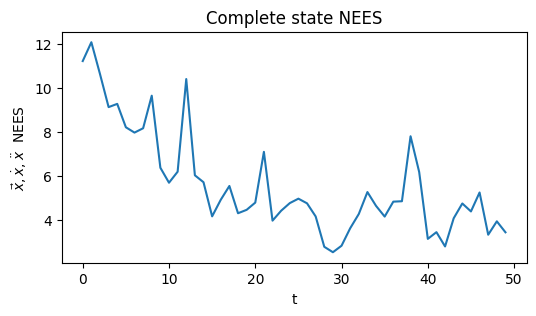

Complete NEES score: 5.615083226038849


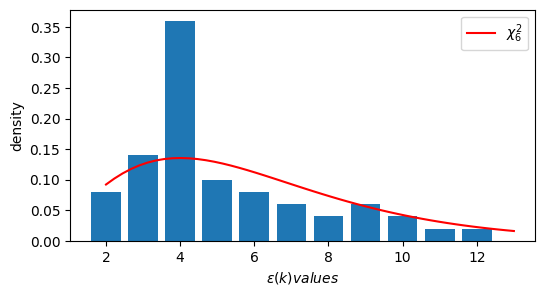

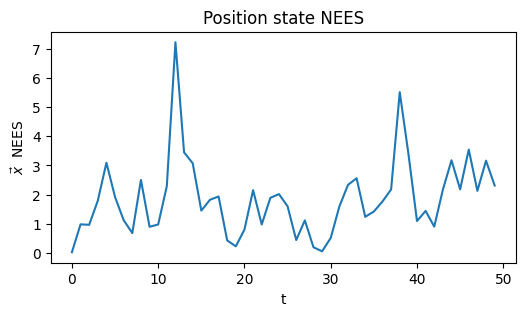

Position NEES score: 1.8521419590449708


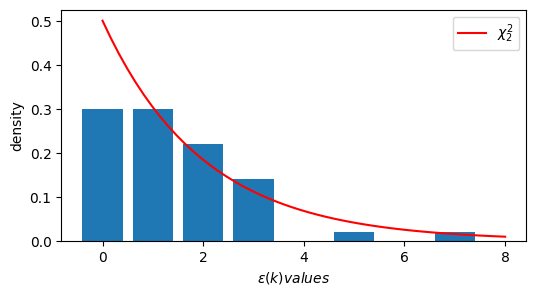

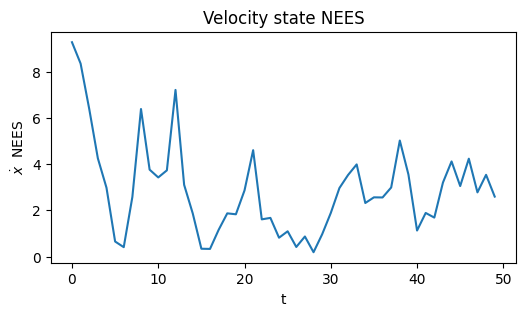

Velocity NEES score: 2.893379246281296


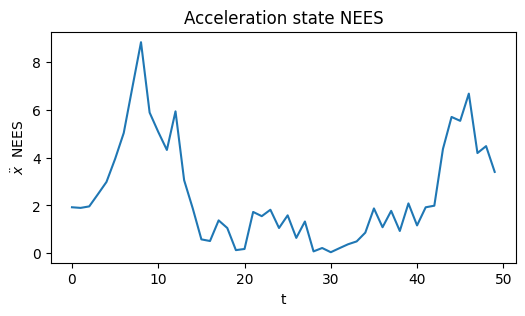

Acceleration NEES score: 2.503600489582321


In [15]:
xs_pos, xs_vel, xs_acc = utils.separate_state_series(xs)
true_xs_pos, true_xs_vel, true_xs_acc = utils.separate_state_series(true_xs)

## COMPLETE state vector NEES 
x_tilde = true_xs - xs
nees_ts = np.full(N, np.nan)
for k in range(N): # TODO can we vectorize this loop?
    nees_ts[k] = x_tilde[k].T @ np.linalg.inv(Ps[k]) @ x_tilde[k]
plt.plot(np.arange(0,N), nees_ts)
plt.title('Complete state NEES')
plt.xlabel('t')
plt.ylabel(r'$\vec{x},\dot{x},\ddot{x}$  NEES')
plt.show()

# A 'good' NEES score is: the average value of the NEES timeseries is less than the dimension of the state vector
print(f'Complete NEES score: {np.mean(nees_ts)}')

# Complete state NEES distribution compared to chi-2
domain = (np.floor(np.min(nees_ts)), np.ceil(np.max(nees_ts)))
# Set the number of histogram bins so each has width unity
num_bins = int(domain[1] - domain[0])
h_vals, bins = np.histogram(nees_ts, bins=num_bins, range=domain, density=True)
plt.bar(bins[:-1], h_vals)
domain_ls = np.linspace(domain[0],domain[1])
plt.plot(domain_ls, chi2.pdf(domain_ls, df=6), color='r', label=r'$\chi^2_6$')
plt.legend()
plt.xlabel(r'$\epsilon(k) values$')
plt.ylabel(r'density')
plt.show()

# POSITION NEES
# The difference between the estimate and the true position state
x_tilde = true_xs_pos - xs_pos
nees_ts = np.full(N, np.nan)
for k in range(N): # TODO can we vectorize these NEES calculation loops?
    nees_ts[k] = x_tilde[k].T @ np.linalg.inv(pos_vars[k]) @ x_tilde[k]
plt.plot(np.arange(0,N), nees_ts)
plt.title('Position state NEES')
plt.xlabel('t')
plt.ylabel(r'$\vec{x}$  NEES')
plt.show()
print(f'Position NEES score: {np.mean(nees_ts)}')

# Position NEES distribution compared to chi-2
domain = (np.floor(np.min(nees_ts)), np.ceil(np.max(nees_ts)))
# Set the number of histogram bins so each has width unity
num_bins = int(domain[1] - domain[0])
h_vals, bins = np.histogram(nees_ts, bins=num_bins, range=domain, density=True)
plt.bar(bins[:-1], h_vals)
domain_ls = np.linspace(domain[0],domain[1])
plt.plot(domain_ls, chi2.pdf(domain_ls, df=2), color='r', label=r'$\chi^2_2$')
plt.legend()
plt.xlabel(r'$\epsilon(k) values$')
plt.ylabel(r'density')
plt.show()

# VELOCITY NEES
x_tilde = true_xs_vel - xs_vel
nees_ts = np.full(N, np.nan)
for k in range(N):
    nees_ts[k] = x_tilde[k].T @ np.linalg.inv(vel_vars[k]) @ x_tilde[k]
plt.plot(np.arange(0,N), nees_ts)
plt.title('Velocity state NEES')
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$  NEES')
plt.show()
print(f'Velocity NEES score: {np.mean(nees_ts)}')

# ACCELERATION NEES
x_tilde = true_xs_acc - xs_acc
nees_ts = np.full(N, np.nan)
for k in range(N): # TODO can we vectorize this loop?
    nees_ts[k] = x_tilde[k].T @ np.linalg.inv(acc_vars[k]) @ x_tilde[k]
plt.plot(np.arange(0,N), nees_ts)
plt.title('Acceleration state NEES')
plt.xlabel('t')
plt.ylabel(r'$\ddot{x}$  NEES')
plt.show()
print(f'Acceleration NEES score: {np.mean(nees_ts)}')

Above we have shown:
- The full state vector $\vec{x}$ (as well as the split out position, velocity, and accelerate state 2-tuples) comply with the $\chi^2_k$ distributions, and that the average value of the NEES series is less than the number of elements in the respective state vector.
- The state vectors $\epsilon(k)$ distributions are indeed $\chi^2_k$, verified by overlaying the actual NEES values histogram with the $\chi^2_k$ pdfs.

__QUESTIONS__:

- I've shown the the NEES values are $\chi^2_k$-distributed, and therefor have the expected values of $k$. How does this related to Labbes informal assertion that as long as average NEES value is $\lt k$ the filter is performing well? Why would it be anything other than equal to k?
  - TODO: Read the paper recommended by labbe.

# Exploring Residuals

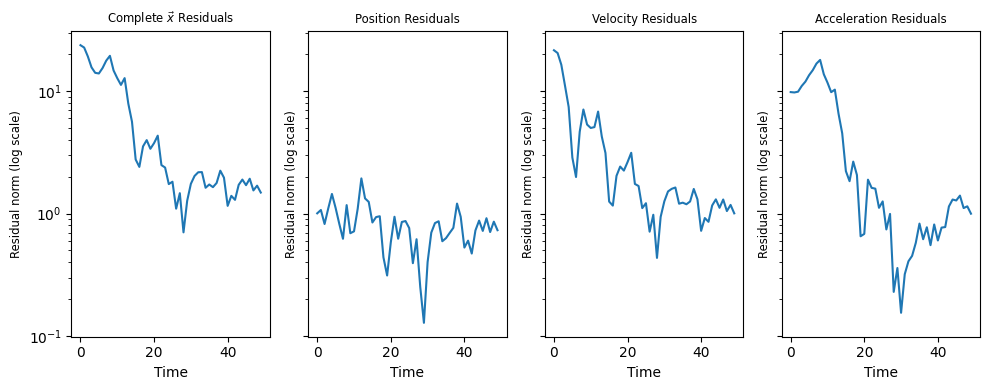

TODO: Why doesn't position residual norm curve look like the others?


In [16]:
# rs = true_xs - xs
# Note this function assumes the given ax is part of a multi subplot figure
def plot_residuals(ax, rs, title=''):
    rs_norms = np.full(N, np.nan)
    for i in range(N):
        rs_norms[i] = np.linalg.norm(rs[i])
    t = np.arange(0,N)
    ax.set_yscale('log')
    ax.plot(t, rs_norms)
    ax.set_title(title, fontsize='small')
    ax.set_xlabel('Time')
    ax.set_ylabel('Residual norm (log scale)', fontsize='small')

# Calculate and plot residuals for multiple (track, estimate) pairs on one figure
def plot_all_residuals_2(tracks, estimates):
    """
    Args:
        tracks: List of true state timeseries
        estimates: List of estimated state timeseries
    """
    fig, axs = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(10,4))
    
    for track, estimate in zip(tracks, estimates):
        xs_pos, xs_vel, xs_acc = utils.separate_state_series(track)
        true_xs_pos, true_xs_vel, true_xs_acc = utils.separate_state_series(estimate)

        # Complete Residuals
        rs = track - estimate
        plot_residuals(axs[0], rs, title=r'Complete $\vec{x}$ Residuals')

        # Position residuals
        rs = true_xs_pos - xs_pos
        plot_residuals(axs[1], rs, title='Position Residuals')

        # Velocity residuals
        rs = true_xs_vel - xs_vel
        plot_residuals(axs[2], rs, title='Velocity Residuals')

        # Velocity residuals
        rs = true_xs_acc - xs_acc
        plot_residuals(axs[3], rs, title='Acceleration Residuals')
    
    plt.tight_layout()
    plt.show()

plot_all_residuals_2([true_xs], [xs])
print('TODO: Why doesn\'t position residual norm curve look like the others?')

# Exploring initial state guess perturbations

- Subconcept: Uniform sampling the surface of a $d$-sphere. [Article (see muller method)](https://extremelearning.com.au/how-to-generate-uniformly-random-points-on-n-spheres-and-n-balls/)
    - TODO: Understand and writeup the reasoning for the muller method: That random normal  components form direction vectors that point to uniform positions on a sphere.
    
Take $d$ draws from $\mathcal{N}(0,1)$.

Form a $d$-dimensional vector $\vec{z}$ from those draws.

Since each component is i.i.d. normal, the joint pdf $f(\vec{z})$ is the product of the individual pdfs (__TODO__ confirm this).

In the 2D case:

$f(u,v) = f(\vec{z}) = \left( \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}u^2} \right) \left( \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}v^2} \right)$

$ \frac{1}{2\pi} e^{-\frac{1}{2}(u^2 + v^2)} = \frac{1}{2\pi} e^{-\frac{1}{2}(|\vec{z}|^2)}$

This implies the joint distribution depends only on the _magnitude_ of $\vec{z}$, not the direction. Therefore the distribution is rotation invariant. i.e The distribution is uniform along the sphere of radius $|\vec{z}|$.


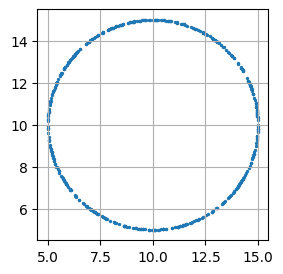

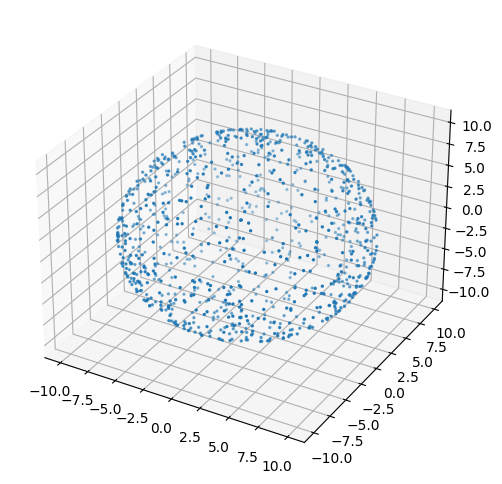

In [17]:
# Testing muller algorithm to generate uniform points on a (d-1)-sphere

# Return a point, selected at uniform random, on a (d-1)-sphere of radius r
def random_point_on_dsphere(r=1, d=2, v0=np.zeros(2)):
    """
    Args
        r: Radius of the d-sphere
        d: Dimension of space. e.g. d=3 creates a sphere (a 2-sphere: 2 degrees of freedom).
        v0: Origin of the d-sphere
    """
    # Pick a d-dimensional direction vector
    # Each component independently drawn from ~N(0,1)
    v = rng.normal(0, 1, d)
    d = np.linalg.norm(v)
    return v0 + (r * v/d)

# d=2: Circle (d-1 = 1 degree of freedom)
figure, axes = plt.subplots(1, figsize=(3,3)) 
axes.set_aspect(1)
r = 5
d = 2
v0 = np.zeros(d) + 10
num_points = 500
points = np.full((num_points,d), np.nan)
for i in range(num_points):
    points[i] = random_point_on_dsphere(r=r, d=d, v0=v0)
axes.scatter(points[:,0], points[:,1], s=2)
plt.grid()
plt.show()

# d=3: Sphere (d-1 = 2 degrees of freedom)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
r = 10
d = 3
v0 = np.zeros(d)
num_points = 1000 # Num points
points = np.full((num_points,d), np.nan)
for i in range(num_points):
    points[i] = random_point_on_dsphere(r=r, d=d, v0=v0)
ax.scatter(points[:,0], points[:,1], points[:,2], s=2)
plt.show()

Random initial state guess: 0% perturbation of true initial state norm:


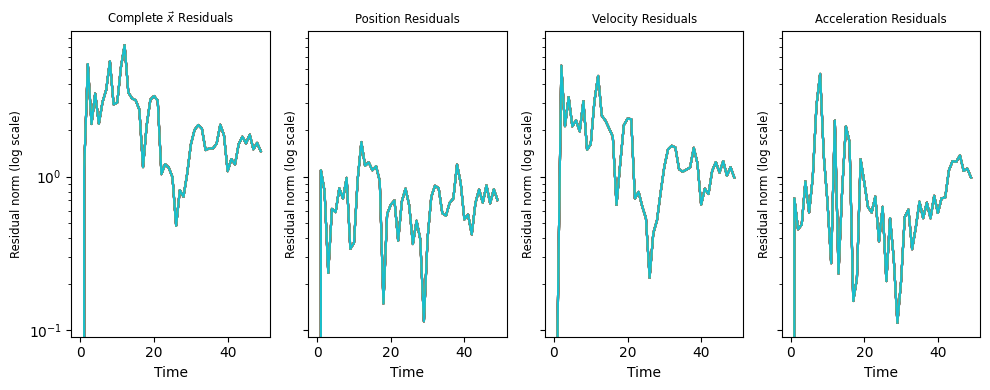

Random initial state guess: 56% perturbation of true initial state norm:


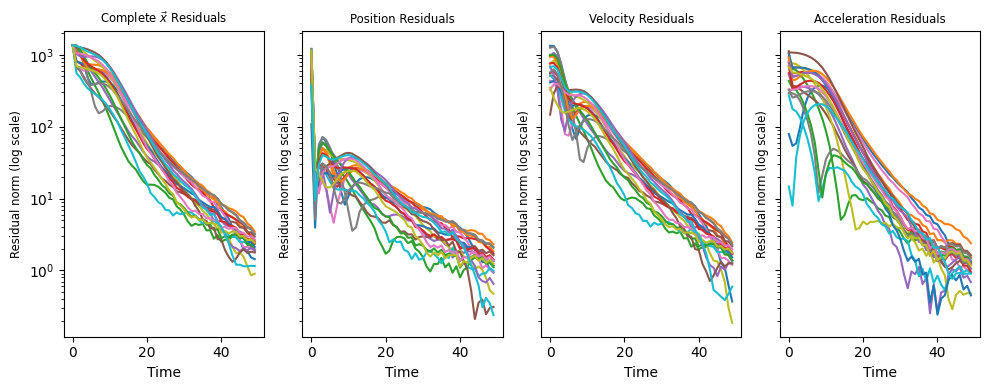

Random initial state guess: 111% perturbation of true initial state norm:


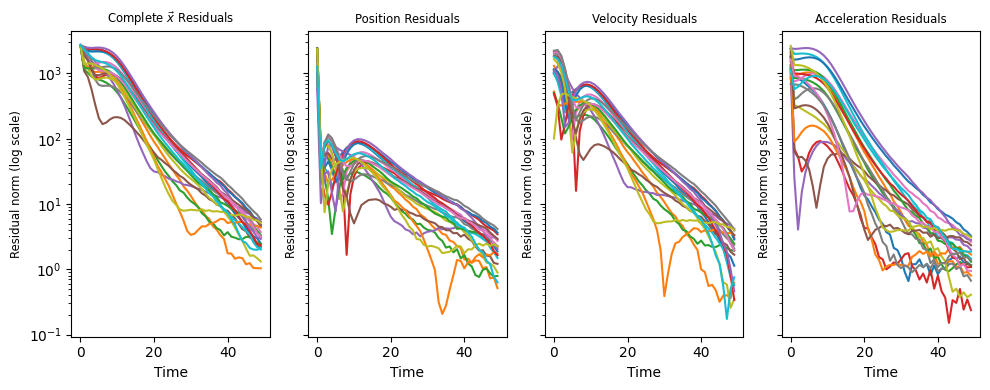

Random initial state guess: 167% perturbation of true initial state norm:


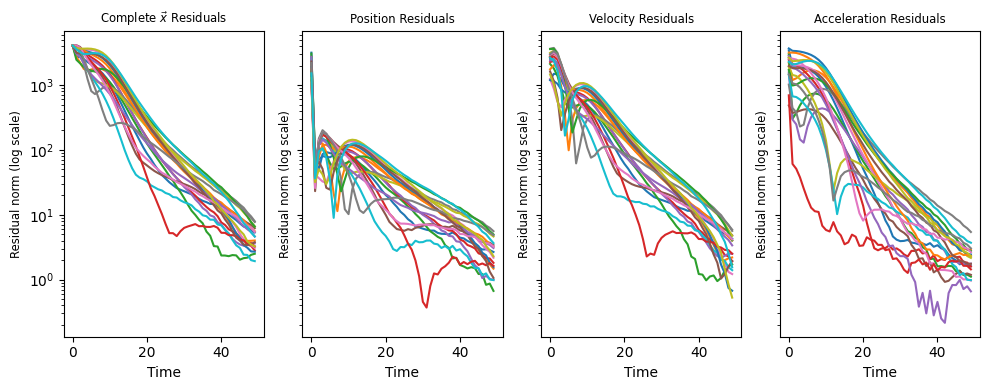

Random initial state guess: 222% perturbation of true initial state norm:


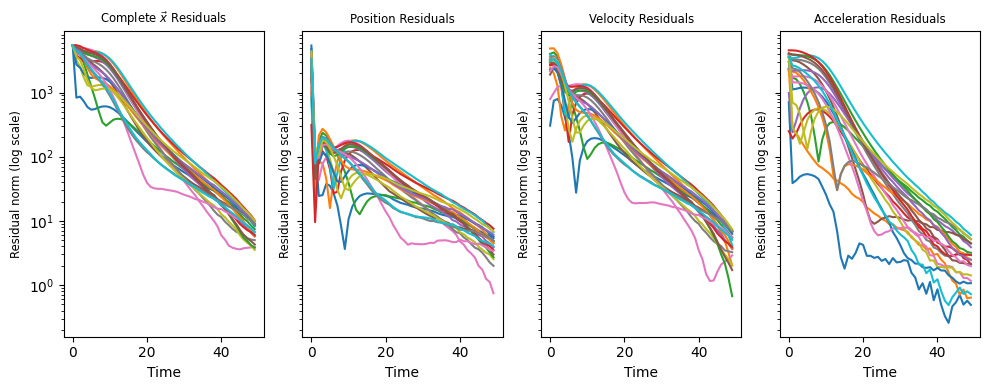

Random initial state guess: 278% perturbation of true initial state norm:


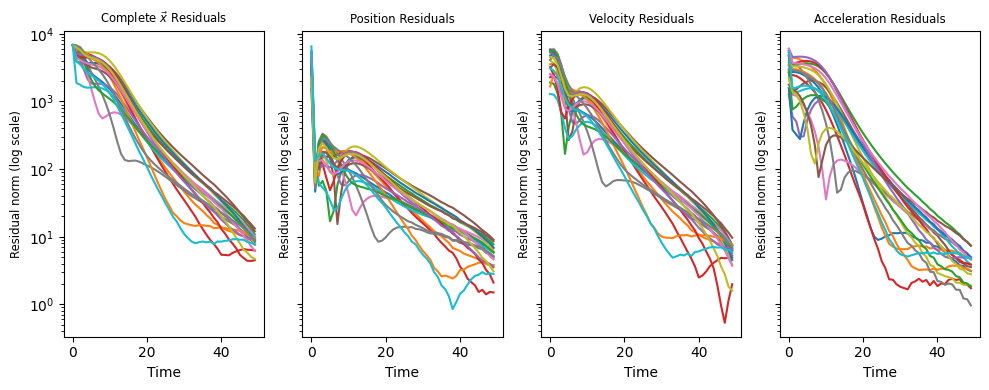

Random initial state guess: 333% perturbation of true initial state norm:


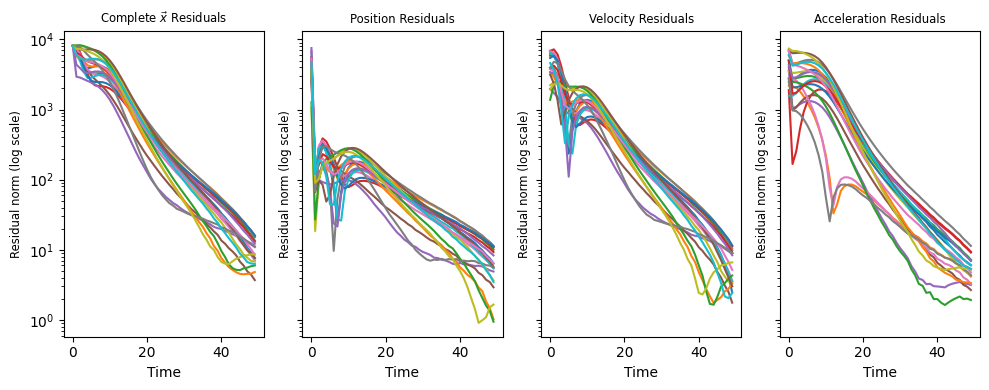

Random initial state guess: 389% perturbation of true initial state norm:


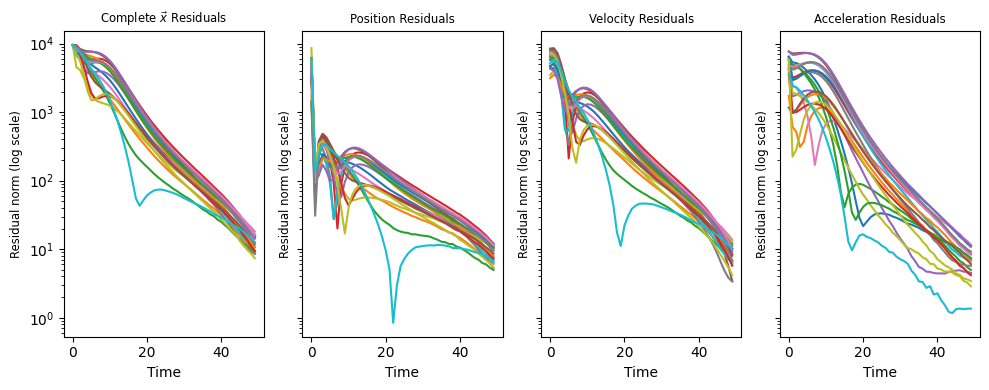

Random initial state guess: 444% perturbation of true initial state norm:


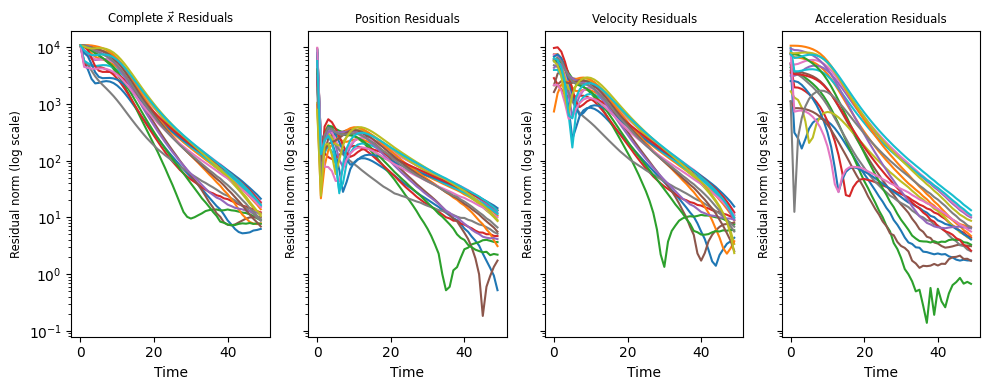

Random initial state guess: 500% perturbation of true initial state norm:


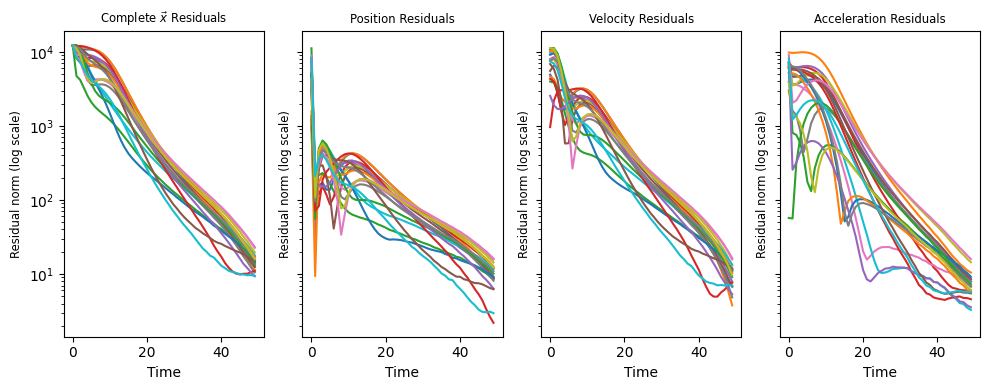

In [18]:
# Config
num_perturbations = 20
d = len(x0)

# For p in a set of increasing distances (in percentage of true x0's norm)
for p in np.linspace(0.0, 500.00, num=10):
    print(f'Random initial state guess: {p:.0f}% perturbation of true initial state norm:')

    # Generate random initial state vectors perturbed by p from true initial state x0
    x0_norm = np.linalg.norm(true_xs[0])
    r = x0_norm * p
    init_points = np.full((num_perturbations, d), np.nan)
    for i in range(num_perturbations):
        init_points[i] = random_point_on_dsphere(r=r, d=d, v0=true_xs[0])
        
    # Run Kalman filter for each initial state guess
    tracks = []
    estimates = []
    for v_0 in init_points:
        P_0 = np.eye(6) * 50 # Start with very low confidence in predictions
        xs, Ps = kalman_6d(zs, R, Q, v_0, P_0)
        # Calculate NEES score
        if len(true_xs) != len(xs):
            print(f'unequal lengths. len(zs)={len(zs)}. len(true_xs)={len(true_xs)}. len(xs)={len(xs)}')
            assert False
        tracks.append(true_xs)
        estimates.append(xs)
    
    plot_all_residuals_2(tracks, estimates) 
    
# Scatter plot NEES as a function of initial distance

# TODO next: 
# - Break the x0 perturbations out by position, velocity, and acceleration. e.g if 
#   position is accurate but acceleration is way off, how does that perform.
# - Plot perturbation distance vs time to acceptable NEES

Notes on above:

- When graphing in log scale, they all appear to have a middle period of linear-looking decline (regardless of initial position). The initial period is more volatile, and the final period is a leveling of (convergence). None converge at zero, which makes sense.

# Exploring parameter space for the multivariable kalman filter example

In our initial exploration, we assumed we could configure the filter's $Q$ and $R$ values perfectly (i.e. to the noise values that were used to generate the synthetic data). But what about the more realistic scenario where we don't know the true $Q$ and $R$ values? 

Let $Q*$ and $R*$ be the true process and measurement noise covariance matrices, respectively.

Below we explore tuning the filter's assumed $Q$ and $R$ covariance matrices to percentages in the range of $[0, 1000]$%.

Q is process noise. R is measurement noise.
Q * 0.0.  R * 0.1.


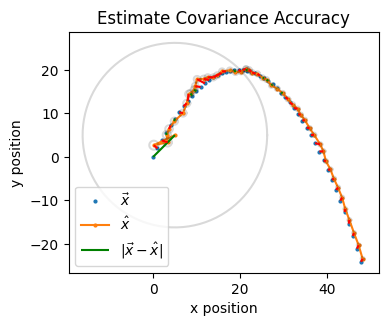

Percent of estimate covar ellipse containing true state: 26.00%


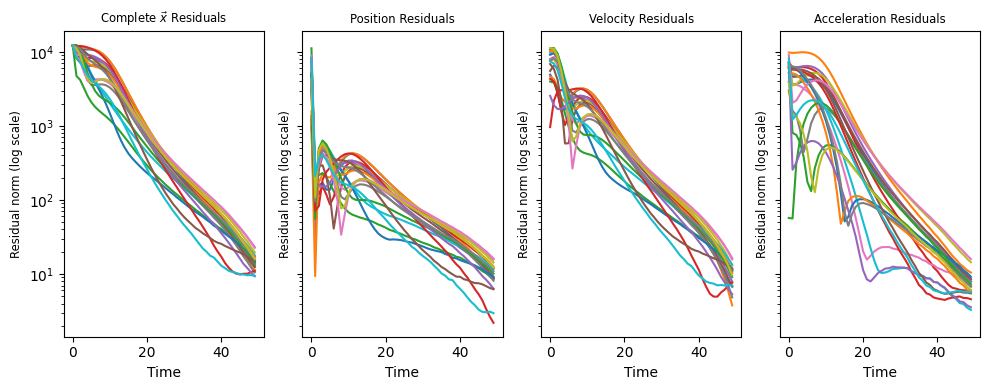

Q * 0.0.  R * 1.7.


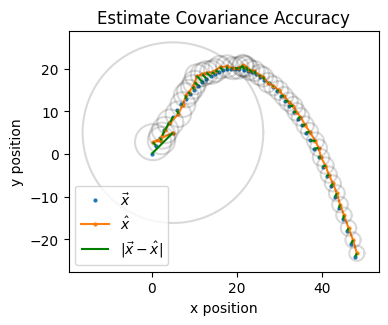

Percent of estimate covar ellipse containing true state: 100.00%


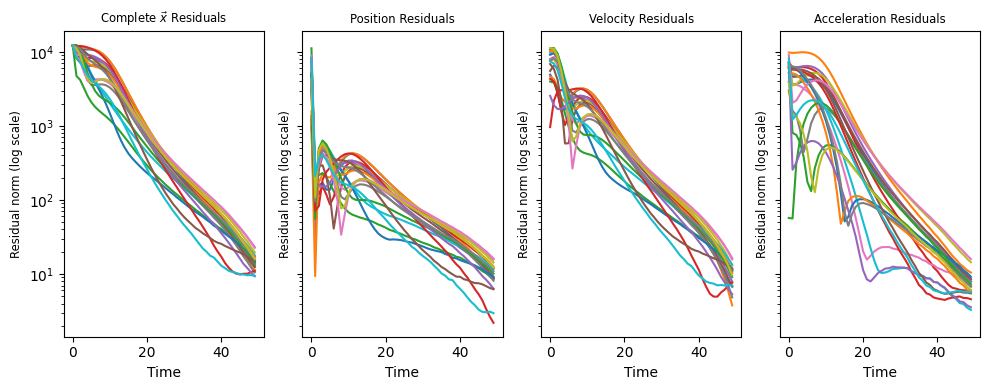

Q * 0.0.  R * 3.4.


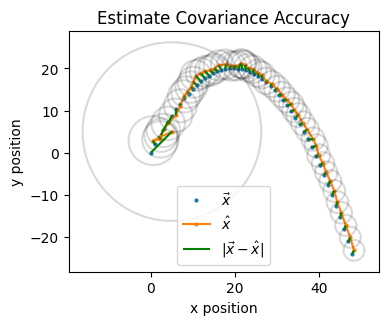

Percent of estimate covar ellipse containing true state: 100.00%


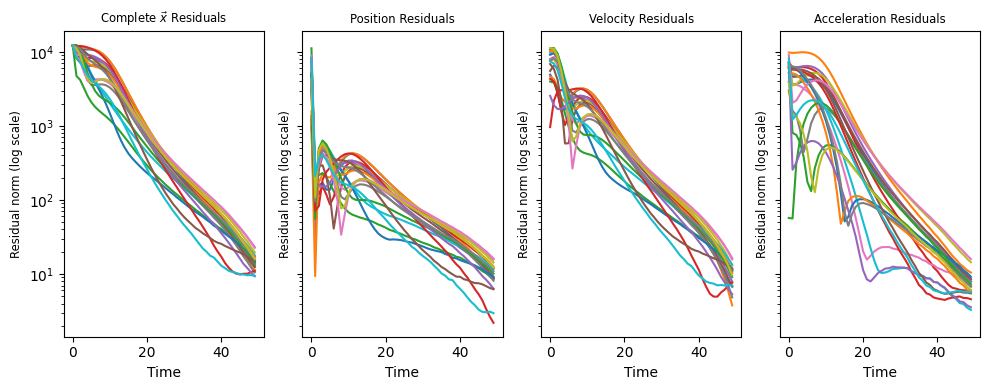

Q * 0.0.  R * 5.0.


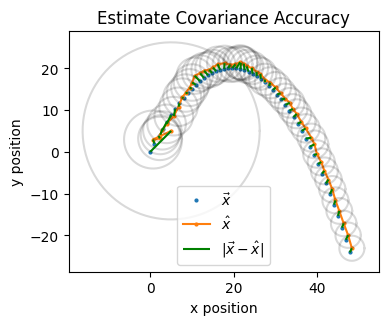

Percent of estimate covar ellipse containing true state: 100.00%


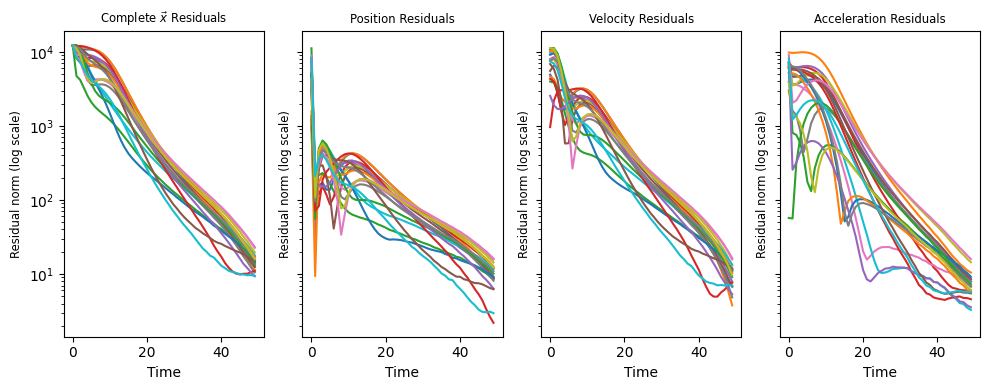

Q * 1.7.  R * 0.1.


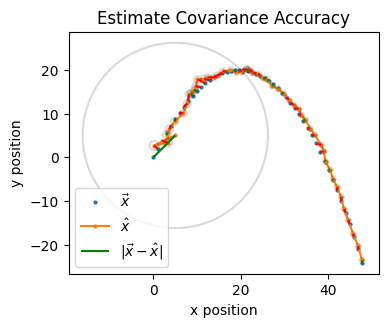

Percent of estimate covar ellipse containing true state: 36.00%


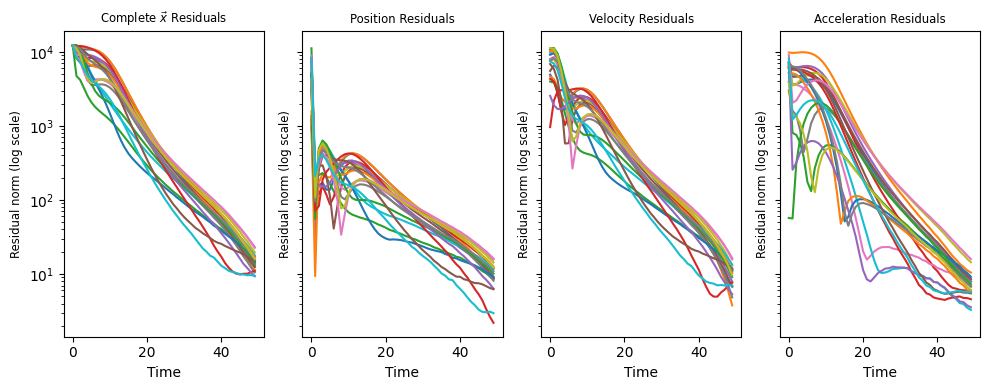

Q * 1.7.  R * 1.7.


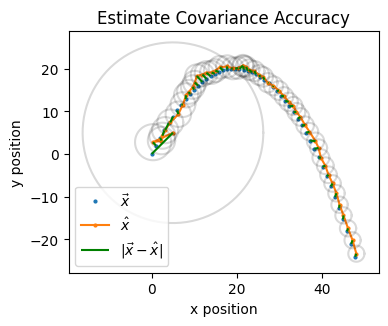

Percent of estimate covar ellipse containing true state: 100.00%


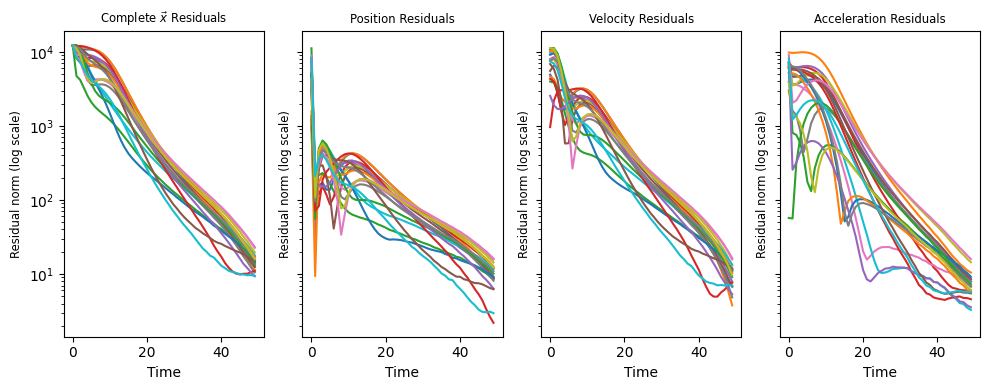

Q * 1.7.  R * 3.4.


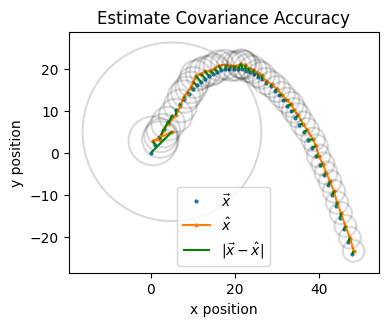

Percent of estimate covar ellipse containing true state: 100.00%


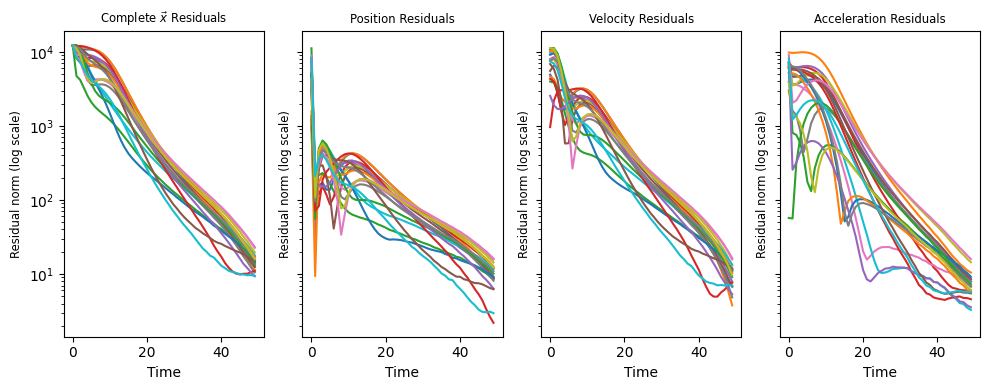

Q * 1.7.  R * 5.0.


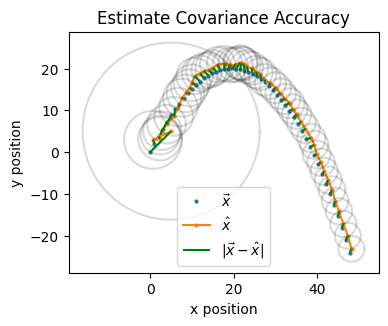

Percent of estimate covar ellipse containing true state: 100.00%


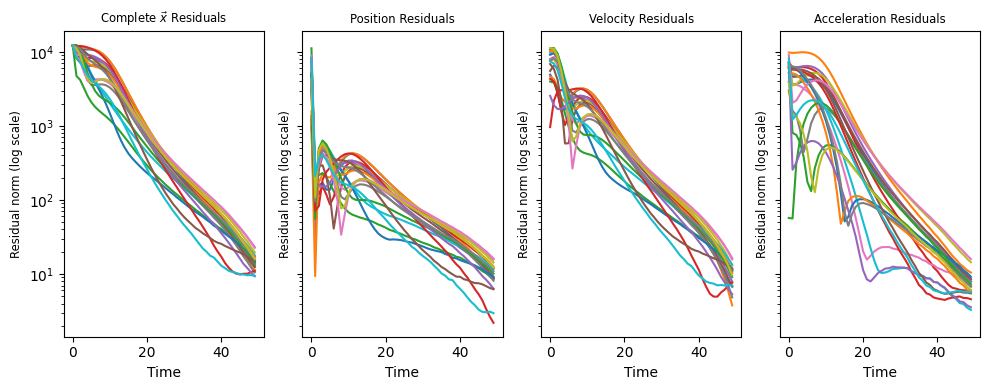

Q * 3.3.  R * 0.1.


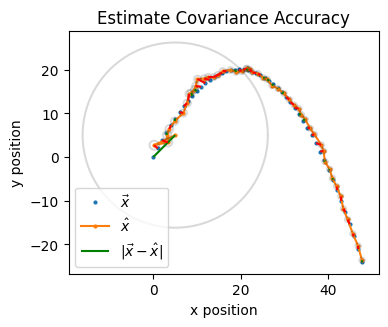

Percent of estimate covar ellipse containing true state: 38.00%


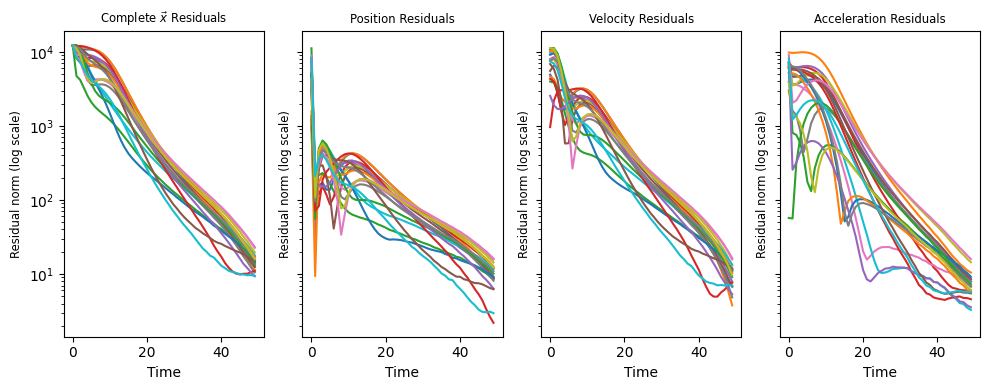

Q * 3.3.  R * 1.7.


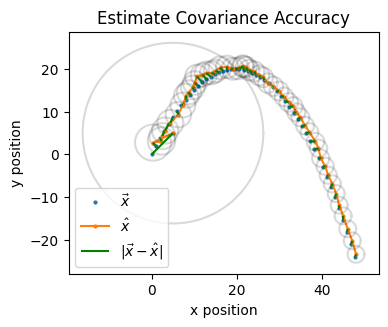

Percent of estimate covar ellipse containing true state: 100.00%


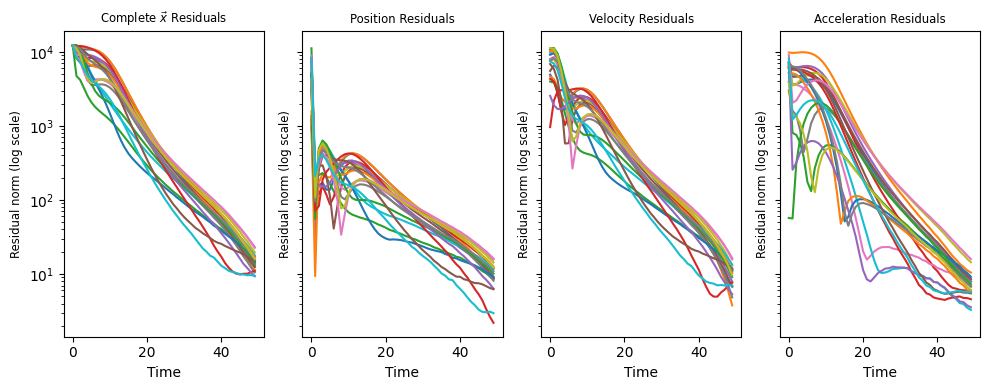

Q * 3.3.  R * 3.4.


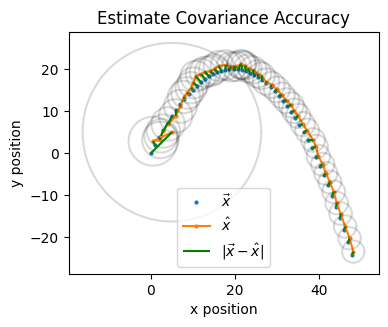

Percent of estimate covar ellipse containing true state: 100.00%


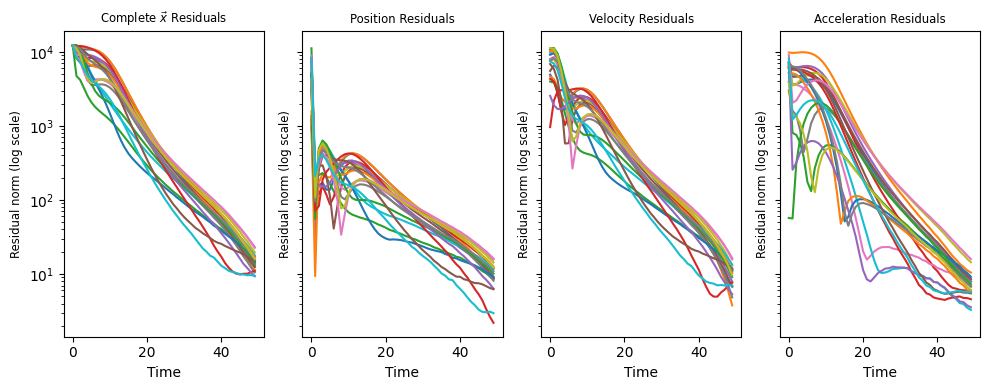

Q * 3.3.  R * 5.0.


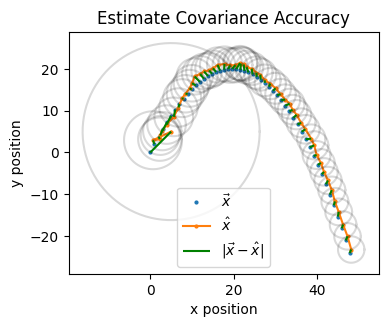

Percent of estimate covar ellipse containing true state: 100.00%


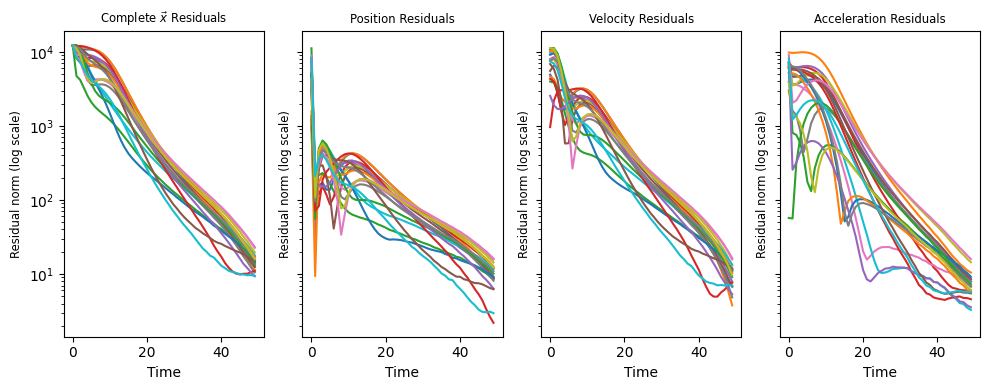

Q * 5.0.  R * 0.1.


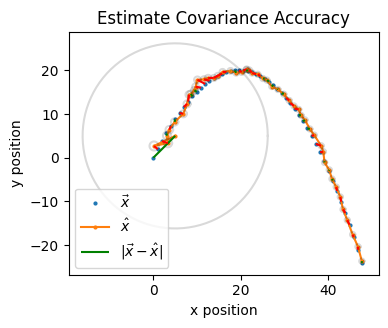

Percent of estimate covar ellipse containing true state: 40.00%


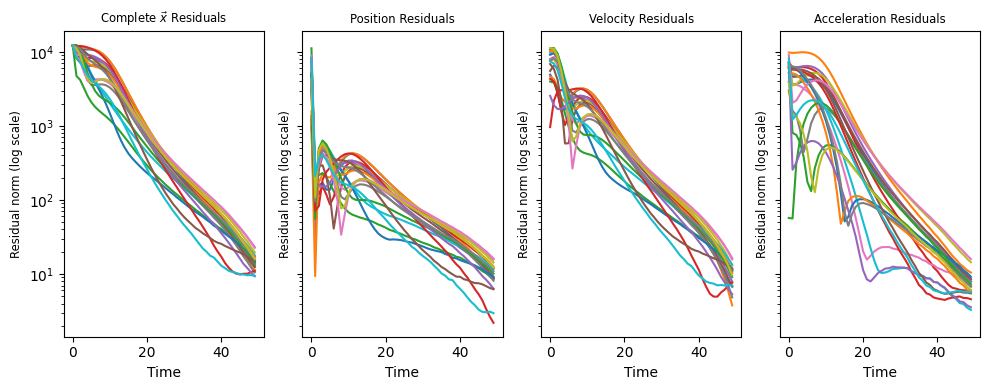

Q * 5.0.  R * 1.7.


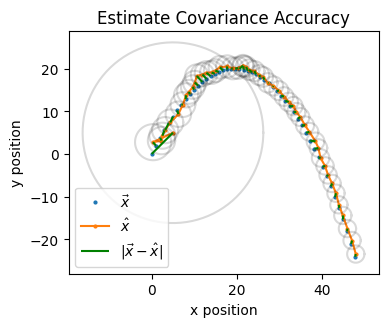

Percent of estimate covar ellipse containing true state: 100.00%


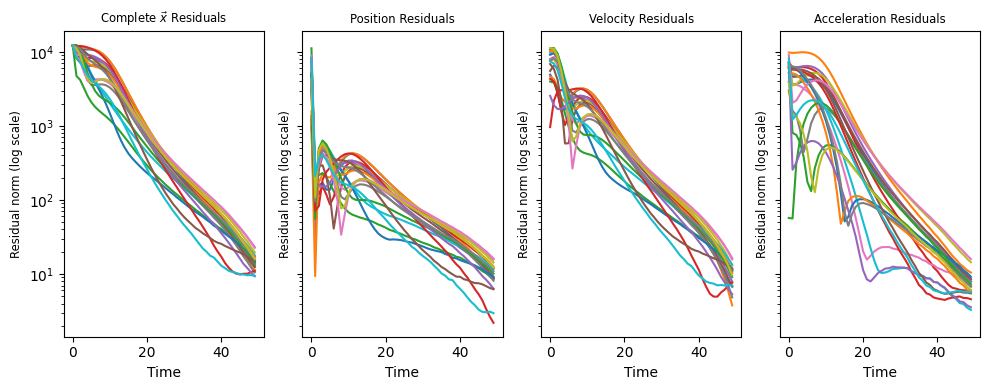

Q * 5.0.  R * 3.4.


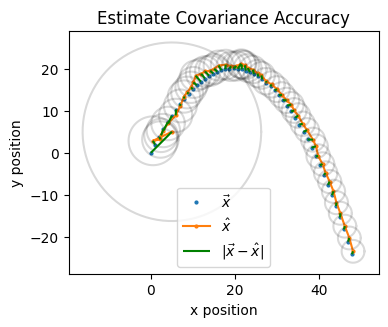

Percent of estimate covar ellipse containing true state: 100.00%


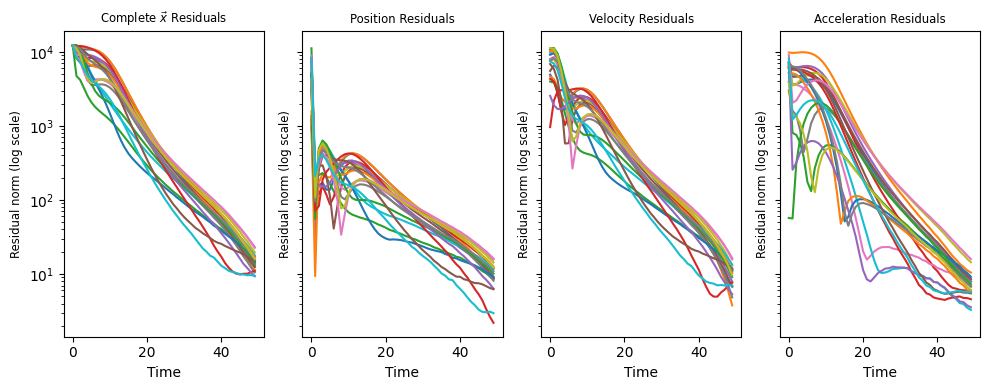

Q * 5.0.  R * 5.0.


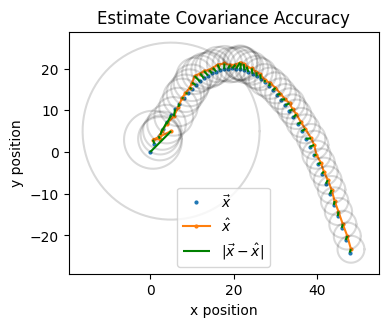

Percent of estimate covar ellipse containing true state: 100.00%


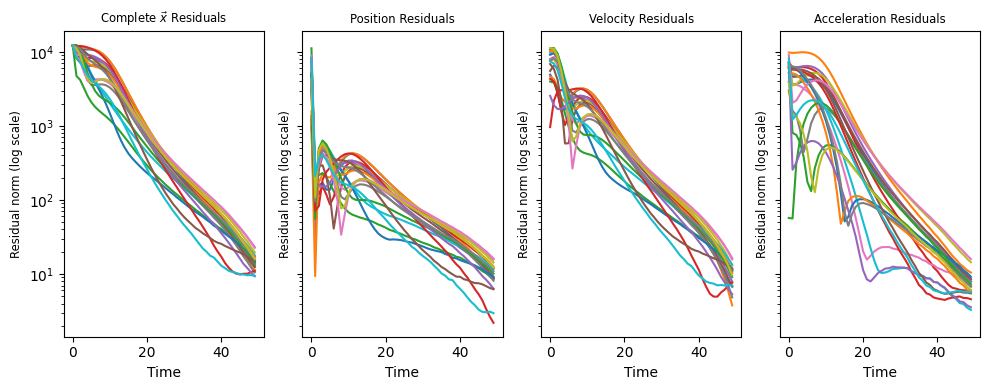

In [19]:
# Iterate through the (Q,R) parameter space 
# In terms of percentages of the true param values
num_iters = 4

print('Q is process noise. R is measurement noise.')

for p_i in np.linspace(10**-6, 5.0, num=num_iters):
    for p_j in np.linspace(10**-1, 5.0, num=num_iters):
        print(f'Q * {p_i:.01f}.  R * {p_j:.01f}.')
        Q = Q_true * p_i
        R = R_true * p_j

        # Run Kalman filter for (Q,R) combo
        P_0 = np.eye(6) * 50 # Start with very low confidence in predictions
        v_0 = np.array([5., 0, 0, 5, 0, 0]) # Start with an ok initial state
        xs, Ps = kalman_6d(zs, R, Q, v_0, P_0)
        
        # Plot track, measurements, and estimate for position
        # plt.rcParams["figure.figsize"] = (10,5)
        # plt.plot(true_xs[:,0], true_xs[:,3], label=r'$\vec{x}$',  marker='o', markersize=2)
        # plt.plot(xs[:,0], xs[:,3], label=r'$\hat{x}$',  marker='o', markersize=2)
        # plt.plot(zs[:,0], zs[:,1], label=r'$\vec{z}$', marker='o', linestyle='none', markersize=2)
        # plt.title('Kalman position estimate')
        # plt.xlabel('x position')
        # plt.ylabel('y position')
        # plt.legend()
        # plt.show()
        xs_pos, _, _ = utils.separate_state_series(xs)
        true_xs_pos, _, _ = utils.separate_state_series(true_xs)
        Ps_pos, _, _ = utils.separate_covar_series(Ps)
        plot_estimate_covar_accuracy(true_xs_pos, xs_pos, Ps_pos, n_std=3.0, 
                             xlabel='x position', ylabel='y position', figsize=(4,4))

        plot_all_residuals_2(tracks, estimates) 
        
        # TODO average NEES score
        # TODO percentage of estimates within 3-sigma of true

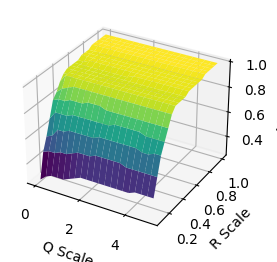

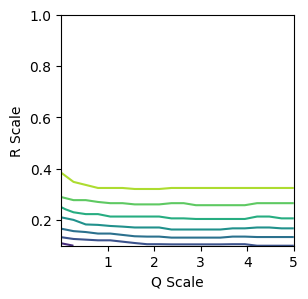

In [20]:
# Attempt 2 at exploring param space

# Run the kalman filter and compute the position estimate covar accuracy score 
# for the given Q_scale and R_scale factor
def covar_accuracy_score(Q_scale, R_scale):
    #print(f'Q_scale:{Q_scale:.04f}. R_scale:{R_scale:.04f}.')
    Q = Q_true * Q_scale
    R = R_true * R_scale

    # Run Kalman filter for (Q,R) combo
    P_0 = np.eye(6) * 50 # Start with very low confidence in predictions
    v_0 = np.array([5., 0, 0, 5, 0, 0]) # Start with an ok initial state
    xs, Ps = kalman_6d(zs, R, Q, v_0, P_0)

    xs_pos, _, _ = utils.separate_state_series(xs)
    true_xs_pos, _, _ = utils.separate_state_series(true_xs)
    Ps_pos, _, _ = utils.separate_covar_series(Ps)
    assert len(xs_pos[0]) == 2
    
    accurate_ellipses = within_confidence_ellipse(true_xs_pos, xs_pos, Ps_pos)
    return np.sum(accurate_ellipses) / len(accurate_ellipses)

# Iterate through the (Q,R) parameter space 
# In terms of percentages of the true param values
num_iters = 20

# The Q and R matrices are simple, they can be represented by their top left corner
# i.e. the variance of the x position
Q_scales = np.linspace(10**-6, 5.0, num=num_iters)
R_scales = np.linspace(10**-1, 1.0, num=num_iters)

# Meshgrid it and calculate surface of accuracy scores
QQ_scales, RR_scales = np.meshgrid(Q_scales, R_scales)
est_ellipse_accuracy_scores = np.vectorize(covar_accuracy_score)(QQ_scales, RR_scales)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(QQ_scales, RR_scales, est_ellipse_accuracy_scores, cmap='viridis')
ax.set_xlabel('Q Scale')
ax.set_ylabel('R Scale')
ax.set_zlabel('Accuracy')
plt.show()


fig, ax = plt.subplots(1, figsize=(3,3)) 
#ax = fig.add_subplot(111, projection='3d')
ax.contour(QQ_scales, RR_scales, est_ellipse_accuracy_scores)
ax.set_xlabel('Q Scale')
ax.set_ylabel('R Scale')
plt.show()
        
# TODO do same contour plot for average NEES score

__TODO__ Things to explore and illustrate:
- Measuring accuracy of the filter.
  - Use the NEES to confirm the _consistency_ of the kalman estimate. Instructions [here](https://kalman-filter.com/normalized-estimation-error-squared/).
- Hidden Variables: i.e. velocity and acceleration in the above model where I only have position sensor.
- __Exploring the relationship between position and velocity covariance (as in Labbe chapter 6 section on "Prediction Equations")__
- Forecasting: Use the trained kalman filter to predict into the future
- Find a better data set on which to demonstrate the filter's usefulness
- Tuning the filter: 
  - What if we're wrong about setting our process and noise uncertainties?
  - Sensitivity to initial guess.
  - For each question, do many filter runs across all parameter states and evaluate the performance:
      - Accuracy rating
      - Amount of steps before 'convergence'
      
      
__TODO__ Things to check or fix
- Confirm your covariance ellipse scale factor is correct. [Looks different than some descriptions - not converting to chi-square s scale factor](https://www.xarg.org/2018/04/how-to-plot-a-covariance-error-ellipse/). OR actually it may be the Mahalanobis distance described [here](https://cookierobotics.com/007/). Check if its right or not.

# Bibliography

```{bibliography}
```